# **Story board**

### 1. Data Exploration (yapping + some visualization about dataset) --> Haige
### 2. Initialize the baseline model + explain about how to improve it ("step 1" of instruction 3) --> Johnny
### 3. Initialize the model and explain about the development of each model one by one. (Here you also discuss the "step 2" of instruction 3) --> everyone
### 4. Compare the best version of everyone's model performance. --> Jason

---
# **Section 1: Data Exploration + Data Preprocessing**

## **Data exploration (Visualization part 1)**
### 1. Loading Data

In [1]:
# Implement here
from pyspark.sql import SparkSession
from util.preprocessing import load_and_preprocess_data

spark = SparkSession.builder.appName("DataExploration").getOrCreate()

# Load data (as in your code)
pre_train_df = load_and_preprocess_data("Twitter_data/pre_traindata7.csv")
train_df = load_and_preprocess_data("Twitter_data/traindata7.csv")
test_df = load_and_preprocess_data("Twitter_data/testdata7.csv")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/22 20:03:21 WARN Utils: Your hostname, Marcuss-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.216 instead (on interface en0)
25/11/22 20:03:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/22 20:03:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/22 20:03:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### 2. Basic Overview
Pre-train data was added for improving performance and reducing overfitting

In [2]:
from pyspark.sql.functions import col, count, when, sum

# Dataset size (row count)
pre_train_count = pre_train_df.count()
print(f"Pre-train size: {pre_train_count} rows, {len(pre_train_df.columns)} columns")

# Schema (data types)
print("\nPre-train schema:")
pre_train_df.printSchema()

print("\n=====================================================================\n")

# Repeat for train_df and test_df as needed, e.g., train_df.count()
train_count = train_df.count()
print(f"Train size: {train_count} rows, {len(train_df.columns)} columns")

# Schema (data types)
print("\nTrain schema:")
train_df.printSchema()
print("\n=====================================================================\n")

test_count = test_df.count()
print(f"Test size: {test_count} rows, {len(test_df.columns)} columns")

# Schema (data types)
print("\nTest schema:")
test_df.printSchema()


Pre-train size: 58907 rows, 2 columns

Pre-train schema:
root
 |-- Phrase: string (nullable = true)
 |-- Sentiment: integer (nullable = true)



Train size: 596 rows, 2 columns

Train schema:
root
 |-- Phrase: string (nullable = true)
 |-- Sentiment: integer (nullable = true)



Test size: 397 rows, 2 columns

Test schema:
root
 |-- Phrase: string (nullable = true)
 |-- Sentiment: integer (nullable = true)



### 3. Analyze Sentiment Distribution
We can see that the dataset is skewed and we need to take it into consideration while training


Pre-train sentiment distribution:
+---------+-----+-------------------+
|Sentiment|count|         proportion|
+---------+-----+-------------------+
|        1|16526|0.28054390819427233|
|        3|14385|0.24419848235354033|
|        2|10256|0.17410494508292731|
|        0|17740|   0.30115266436926|
+---------+-----+-------------------+



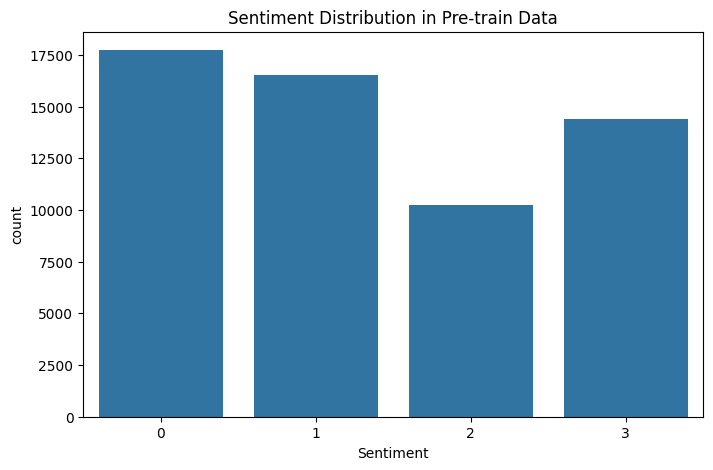


Train sentiment distribution:
+---------+-----+-------------------+
|Sentiment|count|         proportion|
+---------+-----+-------------------+
|        1|  165|0.27684563758389263|
|        3|  147|0.24664429530201343|
|        2|  106|0.17785234899328858|
|        0|  178| 0.2986577181208054|
+---------+-----+-------------------+



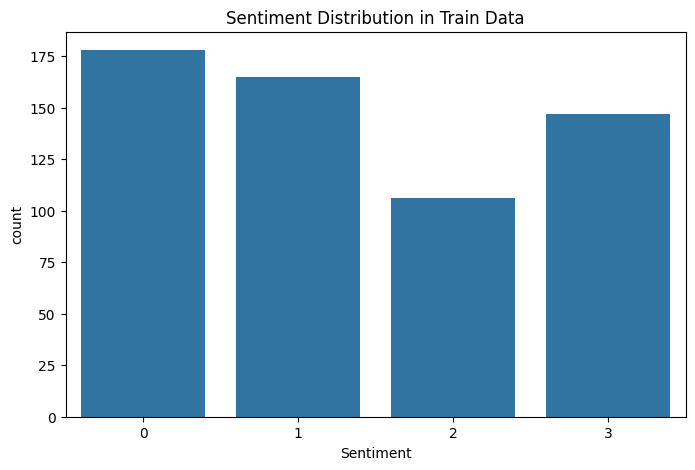


Test sentiment distribution:
+---------+-----+-------------------+
|Sentiment|count|         proportion|
+---------+-----+-------------------+
|        1|  106|0.26700251889168763|
|        3|  105|0.26448362720403024|
|        2|   66|0.16624685138539042|
|        0|  120| 0.3022670025188917|
+---------+-----+-------------------+



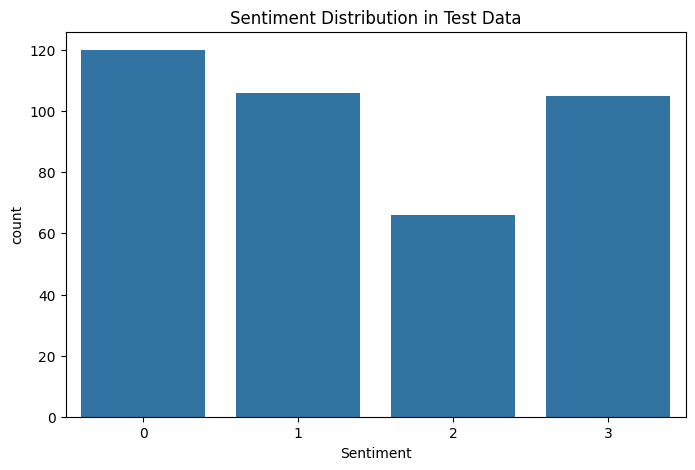

In [3]:
# Implement here
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_sentiment_distribution(df, df_name, df_count):
    sentiment_dist = df.groupBy("Sentiment").count().withColumn("proportion", col("count") / df_count)
    print(f"\n{df_name} sentiment distribution:")
    sentiment_dist.show()

    sentiment_pd = sentiment_dist.toPandas()

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Sentiment', y='count', data=sentiment_pd)
    plt.title(f'Sentiment Distribution in {df_name} Data')
    plt.show()

# Sentiment distribution for pre_train_df
plot_sentiment_distribution(pre_train_df, "Pre-train", pre_train_count)

# Sentiment distribution for train_df
plot_sentiment_distribution(train_df, "Train", train_count)

# Sentiment distribution for test_df
plot_sentiment_distribution(test_df, "Test", test_count)


### 4. Text Length and Word Count Analysis

Pre_train phrase length and word count stats:


+-------+------------------+------------------+
|summary|     phrase_length|        word_count|
+-------+------------------+------------------+
|  count|             58907|             58907|
|   mean|102.33877128354864|19.040266861323783|
| stddev|  74.9428629990796| 14.28738251051899|
|    min|                 1|                 1|
|    max|               950|               198|
+-------+------------------+------------------+



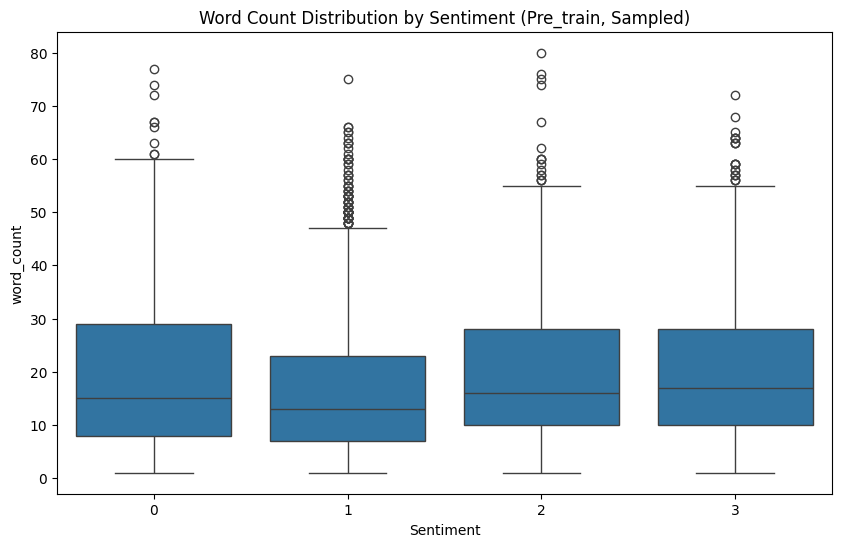

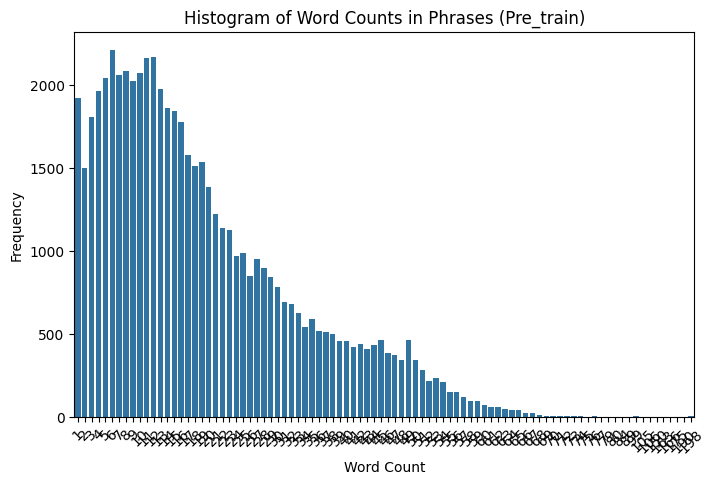

Train phrase length and word count stats:
+-------+------------------+-----------------+
|summary|     phrase_length|       word_count|
+-------+------------------+-----------------+
|  count|               596|              596|
|   mean|112.64261744966443|21.01510067114094|
| stddev| 70.48071286942847| 13.3878700958791|
|    min|                19|                4|
|    max|               345|               65|
+-------+------------------+-----------------+



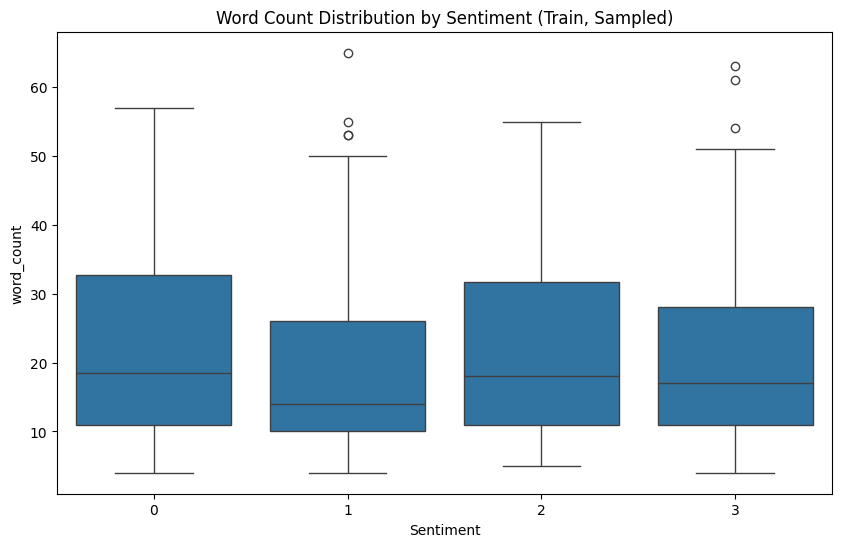

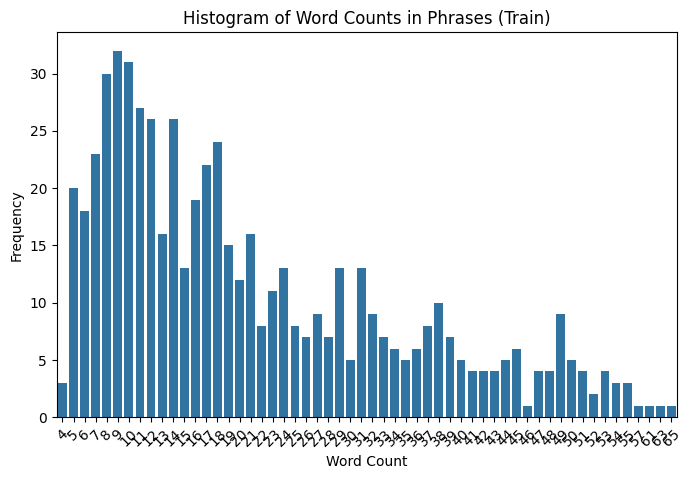

Test phrase length and word count stats:
+-------+-----------------+------------------+
|summary|    phrase_length|        word_count|
+-------+-----------------+------------------+
|  count|              397|               397|
|   mean|112.1486146095718|20.758186397984886|
| stddev|70.98862178955793|13.249812834032232|
|    min|               16|                 5|
|    max|              416|                64|
+-------+-----------------+------------------+



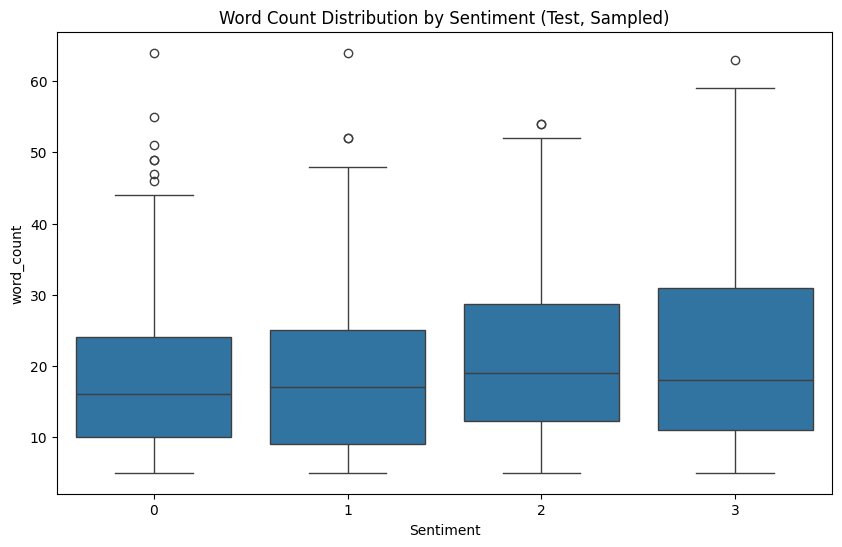

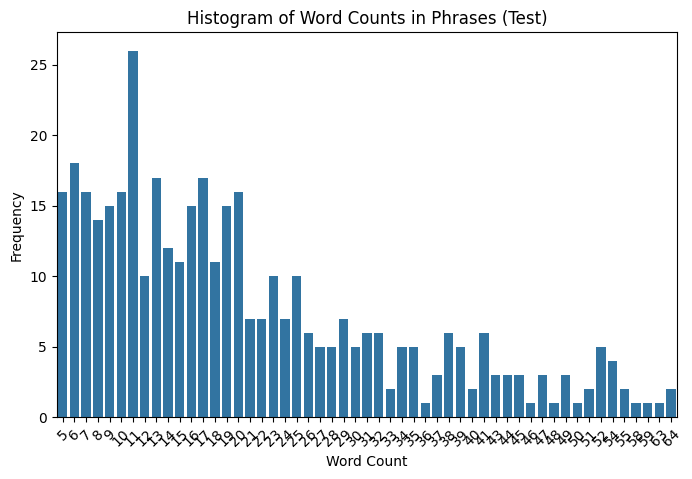

In [5]:
datasets = [
    ("pre_train", pre_train_df),
    ("train", train_df),
    ("test", test_df)
]
from pyspark.sql.functions import length, size, split

for name, df in datasets:
    # Add columns for phrase length and word count (cache if needed for performance)
    df = df.withColumn("phrase_length", length(col("Phrase")))
    df = df.withColumn("word_count", size(split(col("Phrase"), " ")))
    
    # Summary stats
    print(f"{name.capitalize()} phrase length and word count stats:")
    df.select("phrase_length", "word_count").describe().show()
    
    # For boxplot by sentiment, collect a sample to Pandas (to avoid OOM on large data)
    # Use fraction=1.0 for small datasets like train/test
    fraction = 0.1 if name == "pre_train" else 1.0
    sample_pd = df.sample(fraction=fraction, seed=42).select("Sentiment", "word_count").toPandas()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Sentiment', y='word_count', data=sample_pd)
    plt.title(f'Word Count Distribution by Sentiment ({name.capitalize()}, Sampled)')
    plt.show()
    
    # Histogram of word counts (aggregated for efficiency)
    word_count_hist = df.groupBy("word_count").count().orderBy("word_count")
    word_count_pd = word_count_hist.toPandas()
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x='word_count', y='count', data=word_count_pd)
    plt.title(f'Histogram of Word Counts in Phrases ({name.capitalize()})')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
    
    # Update the dataset in the list (since we added columns)
    datasets = [(n, d) if n != name else (name, df) for n, d in datasets]

### 5. Common Words and N-grams

In [6]:
from pyspark.sql.functions import explode, lower, regexp_replace, split
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf

# Fuse all datasets into one
all_df = pre_train_df.union(train_df).union(test_df)

# Prepare words: split, lower, remove punctuation, filter stopwords
all_df = all_df.withColumn("words", split(lower(regexp_replace(col("Phrase"), r"[^\w\s]", "")), " "))
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
all_df = remover.transform(all_df)

# Define bigrams UDF
def get_bigrams(words):
    return [" ".join(words[i:i+2]) for i in range(len(words)-1)] if words else []

get_bigrams_udf = udf(get_bigrams, ArrayType(StringType()))
all_df = all_df.withColumn("bigrams", get_bigrams_udf(col("filtered_words")))

# Define class mappings
class_map = {0: "Negative", 1: "Positive", 2: "Irrelevant", 3: "Neutral"}

# For each class, get top 10 most frequent words and bigrams
for sentiment, label in class_map.items():
    class_df = all_df.filter(col("Sentiment") == sentiment)
    
    # Top 10 most frequent words
    common_words = class_df.select(explode(col("filtered_words")).alias("word")) \
        .filter(col("word") != "") \
        .groupBy("word").count().orderBy(col("count").desc()).limit(10)
    print(f"Top 10 most common words in {label} (Sentiment {sentiment}):")
    common_words.show()
    
    # Top 10 most frequent bigrams
    common_bigrams = class_df.select(explode(col("bigrams")).alias("bigram")) \
        .filter(col("bigram") != "") \
        .groupBy("bigram").count().orderBy(col("count").desc()).limit(10)
    print(f"Top 10 most common bigrams in {label} (Sentiment {sentiment}):")
    common_bigrams.show()

Top 10 most common words in Negative (Sentiment 0):


+----+-----+
|word|count|
+----+-----+
|game| 3601|
| get| 2594|
|fuck| 1713|
|play| 1590|
|like| 1353|
|  go| 1317|
|shit| 1284|
|make| 1158|
|  im| 1142|
| fix| 1126|
+----+-----+

Top 10 most common bigrams in Negative (Sentiment 0):


+-------------------+-----+
|             bigram|count|
+-------------------+-----+
|                   | 1094|
|         home depot|  326|
|        eamaddennfl|  320|
|           johnson |  274|
|       rainbow6game|  271|
|            johnson|  263|
|          call duty|  248|
|     pictwittercom |  235|
|rhandlerr rhandlerr|  196|
|         ghostrecon|  177|
+-------------------+-----+

Top 10 most common words in Positive (Sentiment 1):


+------+-----+
|  word|count|
+------+-----+
|  game| 2459|
|  play| 1837|
|  love| 1638|
|   get| 1575|
|    im| 1468|
|  good| 1417|
|  like| 1199|
|really| 1054|
|     2| 1045|
|    go|  999|
+------+-----+

Top 10 most common bigrams in Positive (Sentiment 1):


+---------------+-----+
|         bigram|count|
+---------------+-----+
|               | 1329|
|       red dead|  499|
|      cant wait|  440|
|dead redemption|  419|
|     home depot|  278|
|   redemption 2|  271|
|assassins creed|  259|
| pictwittercom |  235|
|            _ _|  211|
|       series x|  197|
+---------------+-----+

Top 10 most common words in Irrelevant (Sentiment 2):


+------+-----+
|  word|count|
+------+-----+
|   get|  989|
|   see|  914|
|player|  898|
|  like|  881|
|  game|  876|
|   ban|  748|
|    im|  708|
|    go|  707|
|people|  644|
|  love|  631|
+------+-----+

Top 10 most common bigrams in Irrelevant (Sentiment 2):


+---------------+-----+
|         bigram|count|
+---------------+-----+
|               | 1335|
|       4 player|  299|
|  battlefield 4|  297|
|    italy italy|  294|
|      occur see|  278|
|    see details|  249|
|ban battlefield|  212|
|        player |  209|
|           ban |  207|
|            ban|  186|
+---------------+-----+

Top 10 most common words in Neutral (Sentiment 3):


+-------+-----+
|   word|count|
+-------+-----+
|johnson| 1448|
|   game| 1344|
|    get| 1267|
|   play| 1165|
|      2| 1123|
| amazon|  875|
|   like|  800|
|      _|  799|
|     go|  761|
|     im|  736|
+-------+-----+

Top 10 most common bigrams in Neutral (Sentiment 3):


+---------------+-----+
|         bigram|count|
+---------------+-----+
|               | 2727|
|       johnson |  703|
|        johnson|  650|
|       red dead|  471|
|           com |  438|
|            _ _|  389|
|dead redemption|  367|
|          2020 |  279|
|   redemption 2|  246|
|            tco|  241|
+---------------+-----+



### 6. WordCloud

In [ ]:
from pyspark.sql.functions import explode, col
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ── helper ────────────────────────────────────────────────────────────────────
def plot_wordcloud(freq_dict, title, width=800, height=400, bg='white'):
    if not freq_dict:         # nothing to plot
        return
    wc = WordCloud(width=width, height=height, background_color=bg)
    img = wc.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(img, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# mapping Spark label → readable text
sentiment_names = {0: "Negative", 1: "Positive", 2: "Irrelevant", 3: "Neutral"}

# ── create word-clouds ────────────────────────────────────────────────────────
for name, df in datasets:

    # 1️⃣  Word-cloud for EVERY phrase in the dataset
    all_words = (df.select(explode(col("filtered_words")).alias("word"))
                   .filter(col("word") != "")
                   .groupBy("word").count()
                   .orderBy(col("count").desc())
                   .limit(100))
    plot_wordcloud(
        all_words.toPandas().set_index("word")["count"].to_dict(),
        f"Word Cloud of ALL Phrases ({name.capitalize()})"
    )

    # 2️⃣  One word-cloud per sentiment class that is present
    for label, pretty in sentiment_names.items():
        subset = df.filter(col("Sentiment") == label)

        # skip the class if the dataset contains no rows for it
        if subset.rdd.isEmpty():
            continue

        common = (subset.select(explode(col("filtered_words")).alias("word"))
                         .filter(col("word") != "")
                         .groupBy("word").count()
                         .orderBy(col("count").desc())
                         .limit(100))

        plot_wordcloud(
            common.toPandas().set_index("word")["count"].to_dict(),
            f"Word Cloud of {pretty} Phrases ({name.capitalize()})"
        )

##  **Data Preprocessing**
The function for preprocessing the data is provided here:  
this is stored in the util folder and is used by every model.  
\
Here is what we decided to do:  
- Download Required NLTK Data: Ensure necessary NLTK components are available for lemmatization.
- Read CSV Files: Load the tweet data into Spark DataFrames.
- Clean Tweets:  
<span style="font-size: x-small; text-align: right;">
Remove URLs, user mentions, HTML tags, and special characters.  
Normalize the text by removing extra whitespace and converting it to lowercase.  
Trim leading and trailing whitespace.  
Filter out empty strings and nulls.  
</span> 
- Lemmatization: Apply NLTK's lemmatization to convert words to their base forms.
- Numeric Conversion: Ensure the sentiment column is of numeric type.


\
(We did not remove stop words because comments are already short enough and many small words can express emotion as well)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, lower, trim, udf
from pyspark.sql.types import *
import nltk
from nltk.stem import WordNetLemmatizer

# Goal: universally clean the tweets and output as a spark df

def download_nltk_data():
    """Download required NLTK data."""
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    except LookupError:
        print("Downloading required NLTK data...")
        nltk.download('averaged_perceptron_tagger_eng', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)

def lemmatize(data_str):
    """
    Lemmatize text using NLTK WordNetLemmatizer with POS tagging.
    
    Args:
        data_str: Input string to lemmatize
    
    Returns:
        Lemmatized string
    """
    if not data_str or not isinstance(data_str, str):
        return ''
    
    try:
        lmtzr = WordNetLemmatizer()
        text = data_str.split()
        
        if not text:
            return ''
        
        tagged_words = nltk.pos_tag(text)
        lemmatized_words = []
        
        for word, tag in tagged_words:
            # Determine POS tag for better lemmatization
            if tag.startswith('V'):  # Verb
                lemma = lmtzr.lemmatize(word, pos='v')
            elif tag.startswith('J'):  # Adjective
                lemma = lmtzr.lemmatize(word, pos='a')
            elif tag.startswith('R'):  # Adverb
                lemma = lmtzr.lemmatize(word, pos='r')
            else:  # Default to noun
                lemma = lmtzr.lemmatize(word, pos='n')
            
            lemmatized_words.append(lemma)
        
        return ' '.join(lemmatized_words)
    except Exception as e:
        # If lemmatization fails, return original string
        print(f"Warning: Lemmatization failed: {e}")
        return data_str


def clean_tweets(df, text_column="Phrase"):
    """
    Clean Twitter text data for sentiment analysis.
    
    Args:
        df: Spark DataFrame containing tweet data
        text_column: Name of the column containing tweet text (default: "Phrase")
    
    Returns:
        Spark DataFrame with cleaned text
    """
    cleaned_df = df
    
    # Convert text column to string type if needed
    cleaned_df = cleaned_df.withColumn(text_column, col(text_column).cast(StringType()))
    
    # Remove URLs (http://, https://, www., t.co links)
    cleaned_df = cleaned_df.withColumn(
        text_column,
        regexp_replace(col(text_column), r'http\S+|www\.\S+|https?://\S+|t\.co/\S+', '')
    )
    
    # Remove user mentions (@username)
    cleaned_df = cleaned_df.withColumn(
        text_column,
        regexp_replace(col(text_column), r'@\w+', '')
    )
    
    # Remove HTML entities and special characters like <unk>
    cleaned_df = cleaned_df.withColumn(
        text_column,
        regexp_replace(col(text_column), r'<[^>]+>', '')
    )
    
    # Remove special unicode characters and normalize
    cleaned_df = cleaned_df.withColumn(
        text_column,
        regexp_replace(col(text_column), r'â\S+|â\S+|â\S+', '')
    )
    
    # Remove extra whitespace and newlines
    cleaned_df = cleaned_df.withColumn(
        text_column,
        regexp_replace(col(text_column), r'\s+', ' ')
    )
    
    # Convert to lowercase
    cleaned_df = cleaned_df.withColumn(
        text_column,
        lower(col(text_column))
    )
    
    # Trim leading/trailing whitespace
    cleaned_df = cleaned_df.withColumn(
        text_column,
        trim(col(text_column))
    )
    
    # Remove empty strings (after cleaning, some tweets might become empty)
    cleaned_df = cleaned_df.filter(col(text_column) != '')
    cleaned_df = cleaned_df.filter(col(text_column).isNotNull())

    # Lemmatize the text
    lem_word_udf = udf(lemmatize, StringType())
    cleaned_df = cleaned_df.withColumn(text_column, lem_word_udf(col(text_column)))
    return cleaned_df


def load_and_preprocess_data(file_path, text_column="Phrase", sentiment_column="Sentiment"):
    """
    Load CSV data and preprocess it for sentiment analysis.
    
    Args:
        file_path: Path to the CSV file
        text_column: Name of the text column (default: "Phrase")
        sentiment_column: Name of the sentiment column (default: "Sentiment")
    
    Returns:
        Spark DataFrame with cleaned data
    """

    # Download required NLTK data
    download_nltk_data()

    # Create Spark session
    ss = SparkSession.builder \
        .appName("TwitterSentimentAnalysis") \
        .getOrCreate()
    
    # Read CSV file
    df = ss.read.csv(
        file_path,
        header=True,
        inferSchema=True,
        quote='"',
        escape='"'
    )
    
    # Clean the tweets
    cleaned_df = clean_tweets(df, text_column)
    
    # Ensure sentiment column is numeric
    cleaned_df = cleaned_df.withColumn(
        sentiment_column,
        col(sentiment_column).cast(IntegerType())
    )

    return cleaned_df


# Example usage:
# train_df = load_and_preprocess_data("Twitter_data/traindata7.csv")
# test_df = load_and_preprocess_data("Twitter_data/testdata7.csv")

if __name__ == "__main__":
    train_df = load_and_preprocess_data("../Twitter_data/traindata7.csv")
    test_df = load_and_preprocess_data("../Twitter_data/testdata7.csv")
    train_df.show(10)
    test_df.show(10)

---
# **Section 2: Baseline Model: DF-IDF + Logistic Regression**

In [8]:
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
import spark

# Load the model
pipeline_model_base = PipelineModel.load("model6/baseline")

spark = (
    SparkSession.builder
    .appName("inference")
    .getOrCreate()
)

# Example text string to convert to DataFrame
input_text= [("I love this amazing thing!", "I hate whatever that was")]
new_df = spark.createDataFrame(input_text, ["Phrase"])

# Preprocess data
from util.preprocessing import clean_tweets
cleaned_new_df = clean_tweets(new_df, text_column="Phrase")

# Predict
predictions = pipeline_model_base.transform(cleaned_new_df)
predictions.select("Phrase", "prediction").show()

# Change above example with this line to use 'dfidf_svm'
# Load the model
pipeline_model_base = PipelineModel.load("model6/dfidf_svm")

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from util.preprocessing import load_and_preprocess_data

test_df = load_and_preprocess_data("./Twitter_data/testdata7.csv")
predictions = pipeline_model_base.transform(test_df)
print(predictions)

print("----------")
evaluator = MulticlassClassificationEvaluator(
    labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

25/11/22 20:09:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------------+----------+
|              Phrase|prediction|
+--------------------+----------+
|i love this amazi...|       1.0|
+--------------------+----------+



25/11/22 20:09:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


DataFrame[Phrase: string, Sentiment: int, words: array<string>, rawFeatures: vector, features: vector, rawPrediction: vector, prediction: double]
----------


Test Accuracy: 0.4358


In [9]:
# --- Spark imports ---
import pyspark.sql.functions as F

# 1.  Make sure the column is really integer-typed (optional but clean)
predictions_int = predictions.withColumn(
    "prediction_int", F.col("prediction").cast("int")
)

# 2.  Pull that single column back to the driver and flatten it
pred_list_base: list[int] = (
    predictions_int
        .select("prediction_int")      # DataFrame[ prediction_int: int ]
        .rdd                           # -> RDD[Row(prediction_int=int)]
        .flatMap(lambda row: row)      # -> RDD[int]
        .collect()                     # -> list[int]
)

print(pred_list_base)     # e.g. [1, 0, 2, 1, 1, ...]

[0, 2, 1, 3, 0, 3, 0, 2, 3, 0, 0, 2, 3, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 3, 1, 1, 3, 3, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 3, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 3, 0, 0, 2, 0, 3, 1, 1, 3, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 3, 1, 1, 0, 3, 0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 1, 3, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 3, 1, 0, 2, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 3, 2, 2, 0, 1, 1, 1, 0, 2, 2, 1, 2, 2, 0, 2, 0, 1, 3, 1, 3, 3, 1, 3, 0, 2, 0, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 3, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 3, 1, 1, 0, 0, 2, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 3, 0, 1, 2, 1, 3, 2, 1, 2, 1, 1, 3, 3, 2, 3, 2, 2, 1, 1, 1, 1, 0, 2, 1, 3, 2, 1, 3, 3, 1, 3, 2, 1, 0, 3, 0, 3, 1, 3, 3, 2, 1, 3, 1, 1, 2, 3, 1, 3, 2, 3, 2, 3, 2, 3, 1, 3, 0, 2, 3, 1, 1, 1, 2, 

---
# **Section 3 Model 1: BERT + Deep Neural Network**

In this part, we introduce models that has utilize BERT (word embedding part) and DNN (data analytics part) as their core architecture. Since the provided dataset is quite small for the complex models, we decided to freeze the BERT (we use the model from Huggingface: google-bert/bert-base-uncased), and develop only the DNN part. Here we will discuss how we developed it, what kind of problem we faced, and how we solve it to be the final version of model1 (BERT + DNN)

### BERT + DNN (MLP) without pretraining
This is our first attempt in creating DNN, so we want to try the simplest architecture first, namely MLP. The flow of the pipeline is listed below:
1. Tokenize (BertTokenizer) and embed the sequence of tokens (BertModel)
2. Take only the class token [CLS] from the embeded the sequence of tokens (the first one). --> shape: (B, 768)
3. Pass the [CLS] embbeding to MLP that has the hidden layers size of 512, 512, 256, 128, 64, 32, and 16, respectively.
4. Train wit cross-entropy loss and record on wandb (this is for production grade development).

Below is training training result of the BERT + MLP copied from Phurinut's wandb:

<center><img src="./model1/img/BERT_MLP.png" style="width:800px;"></center>

### BERT + DNN (MLP) + Learning Rate Scheduling (without pretraining)
Previously, we can see from the train_loss_step plot that the loss can't go down and the error remains relatively high. This make us think that maybe the learning rate is too high near the end of the training, and once the optimizer get closer to the local minima exploding gradient issue might happen. Therefore, we create the code that helps schedule the learning rate. Checkout method *_create_scheduler()* in <a href="./model1/pipeline.py">BertDNNPipeline</a>.

Below is the traininig result of the BERT + MLP + Learning Rate Scheduler copied from Phurinut's wandb:

<center><img src="./model1/img/MLP_Learning_Rate_Scheduler.png" style="width:800px;"></center>

Here we can see that the loss coming down a bit more and have a higher fluctuation, but on average it got stuck around 1.1 and the validation accuracy also converged to around 46%.

### BERT + DNN (ResNet) + Learning Rate Scheduling (without pretraining)
With the result we see above, we are more certain that now the gradient start vanishing instead. To tackle with this problem, we introduce a residual connection within the DNN block so that the weight updates can be passed deeper during the backpropagation. Please checkout the implementation in <a href="./model1/dnn.py">BertDNN</a>. The training performance of this model is very good as shown below, so we use it as the final architecture of model 1 (BERT + DNN), and wrap everything up as a pipeline for easier training and fine-tuning purpose. Here is the final pipeline: <a href="./model1/pipeline.py">BertDNNPipeline</a>.

<center><img src="./model1/img/BERT_ResNet_No_pretrain.png" style="width:800px;"></center>

### BERT + DNN (ResNet) + Learning Rate Scheduling (with pretraining)
Unfortunately, after we test it on the testing dataset, we find out that the accuracy is just around 20%. This means that the model severely overfit, and the main reason behind this is clearly because of the small dataset we have. Therefore, we came up with the idea to pretrain the model first on a larger dataset for around 30 epochs using <a href="./model1/pretrain.py">pretrain.py</a>, and fine-tune the model on the provided dataset for another 20 epochs using <a href="./model1/train.py">train.py</a>.

Here is how the pretraining went out:

<center><img src="./model1/img/Pretrain.png" style="width:800px;"></center>

And, this is how the fine-tuning went out:

<center><img src="./model1/img/Fine_tune.png" style="width:800px;"></center>

Now, the testing result becomes a lot better. We acheived a 73.05% accuracy at the end, and the training loss stay relatively low at around 0.8.

Below shows how to run the trained model. If you are looking fine-tuning or model evaluating, please checkout this <a href="./model1/README.md">Guideline</a>.

In [10]:
# installing all the nescessary model 1's weight from Phurinut's Huggingface

!hf download PhurinutR/twitter-sentiment-analysis --include "checkpoints/**" --local-dir ./model1
!hf download PhurinutR/twitter-sentiment-analysis --include "final_model/**" --local-dir ./model1
!hf download PhurinutR/twitter-sentiment-analysis --include "final_model_finetuned/**" --local-dir ./model1

Fetching 5 files: 100%|█████████████████████████| 5/5 [00:00<00:00, 2388.01it/s]
/Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/model1
Fetching 5 files: 100%|█████████████████████████| 5/5 [00:00<00:00, 4015.22it/s]
/Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/model1
Fetching 5 files: 100%|█████████████████████████| 5/5 [00:00<00:00, 5229.81it/s]
/Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/model1


In [11]:
# Initialize the model1 pipeline
from model1.pipeline import BertDNNPipeline
model1_pipeline = BertDNNPipeline.load(
    "./model1/final_model_finetuned",
    head_hidden_dims=[512, 512, 256, 128, 64, 32, 16],
    num_classes=4,
    use_wandb=False
)

# The pipeline is now ready to use, here is some example to run the prediction:
example_tweets = [
    "Playing with Oscar at Fifa gives me grey hair",
    "Working at nvidia should be a nice experience",
    "bruuuhhh oh wtf is wrong with me these good gay ass pc players",
    "Nvidia GeForce Now: Google Stadia rival suffers another blow news89.net / nvidia-geforce... https: / / t.co / 9ijNjV7L4C"
]

predictions = model1_pipeline.predict(example_tweets)
for i, tweet in enumerate(example_tweets):
    print(f"Tweet: {tweet} => Predicted Sentiment: {predictions[i]}")

Using device: mps
Tweet: Playing with Oscar at Fifa gives me grey hair => Predicted Sentiment: 2
Tweet: Working at nvidia should be a nice experience => Predicted Sentiment: 1
Tweet: bruuuhhh oh wtf is wrong with me these good gay ass pc players => Predicted Sentiment: 0
Tweet: Nvidia GeForce Now: Google Stadia rival suffers another blow news89.net / nvidia-geforce... https: / / t.co / 9ijNjV7L4C => Predicted Sentiment: 3


In [12]:
# Nevertheless, for quick accuracy evaluation, you can use the following code:
# This only evaluate the accuracy of the model on the any dataset provided.
# Here we show the evaluation result of the model on the provided test dataset.
# If you want to evaluate the model using other matrices, you have to run model1_pipeline.predict(), 
# and apply the result to your own evaluation function.

from model1.text_dataset import TextDataset
from torch.utils.data import DataLoader

test_dataset = TextDataset(mode="test", tokenizer=model1_pipeline.tokenizer, max_length=model1_pipeline.max_length)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
test_acc = model1_pipeline.evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

# Please see *Section 4* for more test results.

Test Accuracy: 0.7305


---
# **Section 3 Model2: GloVe + LSTM**

#### tokenization (SpaCy 'en_core_web_trf'), GloVe-840B embeddings build 250k-word vocab. 
#### Bidirectional LSTM (1-5 layers, 256 hid, 900-4500 embed, 0.5-0.7 dropout) trains 125 epochs, batch 64, AdamW 1e-3, weight-decay 1e-4, gradient-clip 5. 

#### The old data is not enough causing non ideal result , even for best result it will be near 42% testing acc.
#### After increasing the training dataset the results boosted significantly to around 90% where the best testing acc is 99.7% with only 1 mistake

In [ ]:
!python -m spacy download en_core_web_sm

### old_data part (Using the standard dataset, no pre-trained)


Preview
                                    TrainLoss  TrainAcc  TestLoss  TestAcc
layers bidir emb_dim dropout Epoch                                        
1      True  900     0.5     1         1.3851    0.2991    1.3565   0.3345
                             2         1.2482    0.4863    1.3424   0.3367
                             3         1.1446    0.5725    1.3434   0.3523
                             4         1.0629    0.6231    1.3236   0.3568
                             5         0.9470    0.7278    1.3332   0.3613


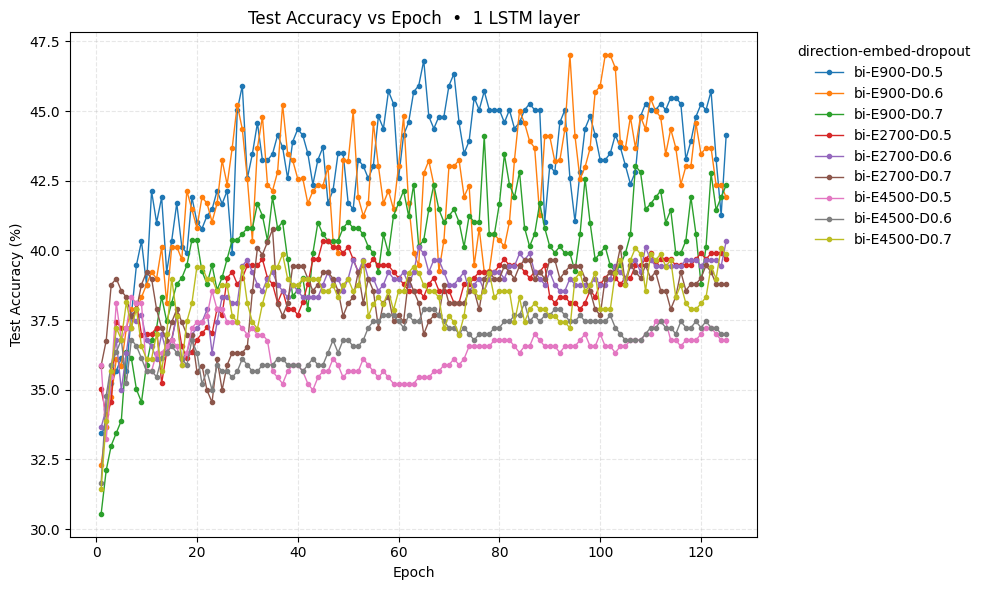

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers1.png


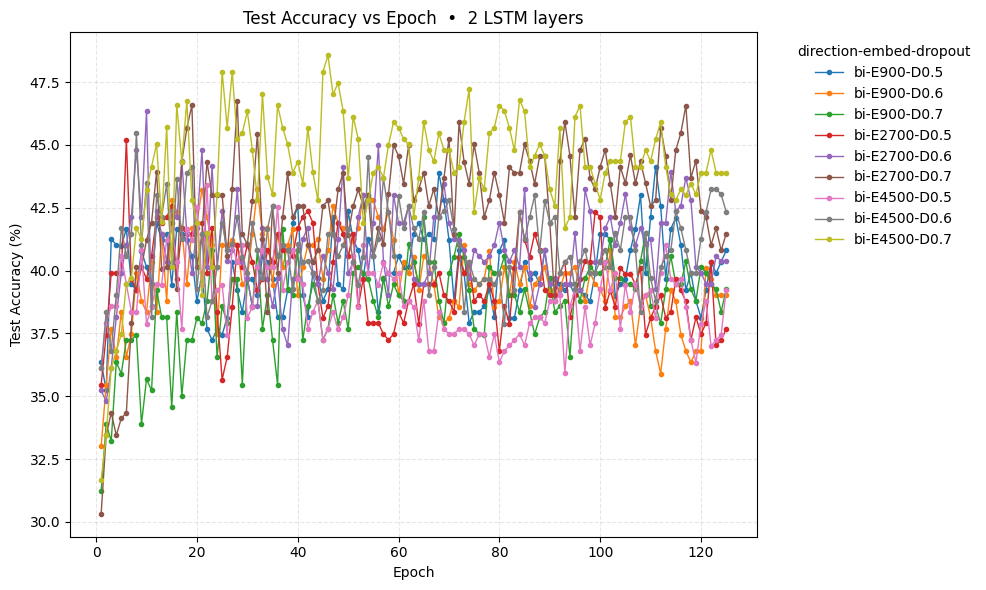

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers2.png


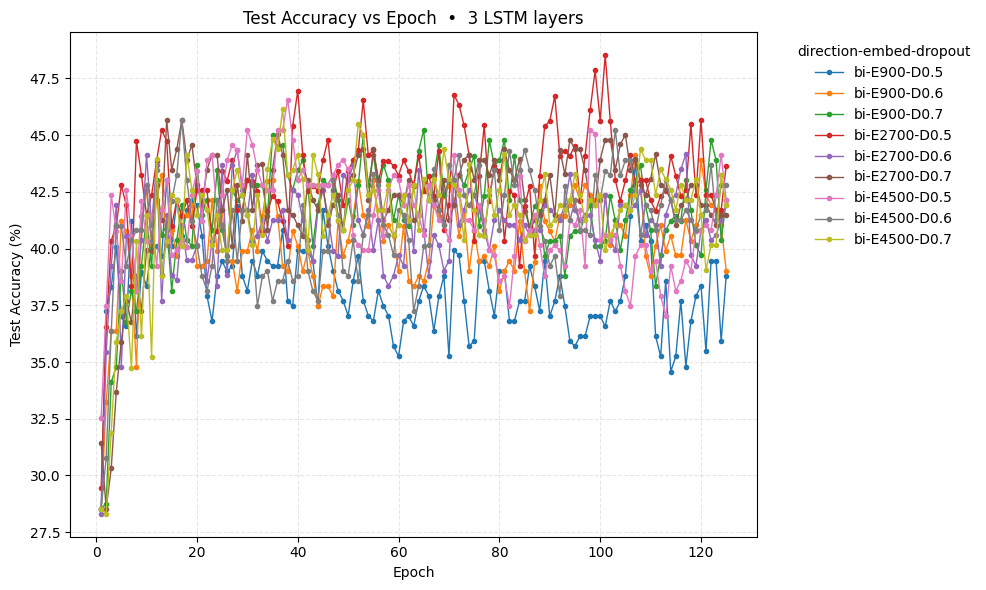

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers3.png


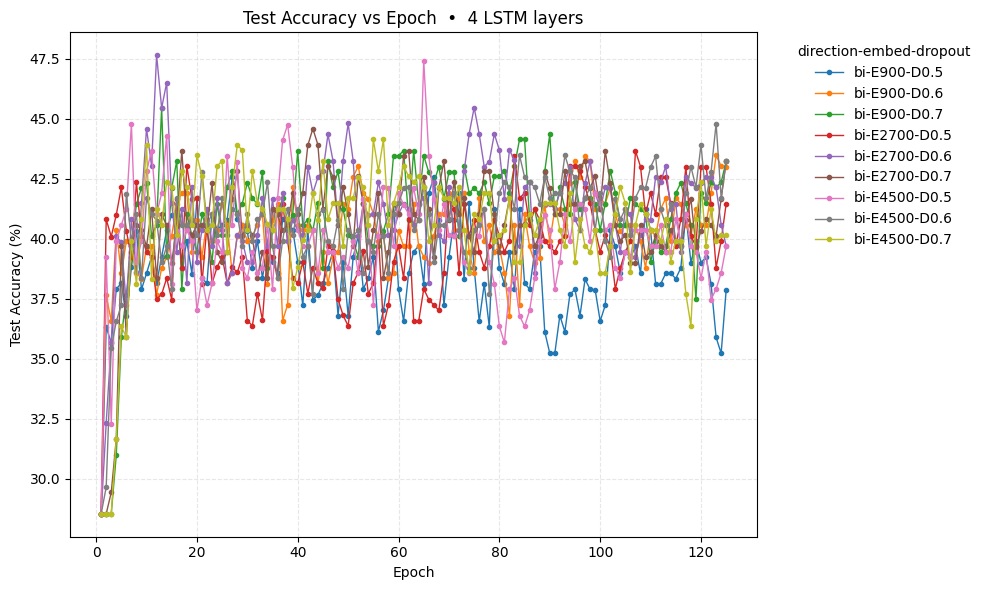

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers4.png


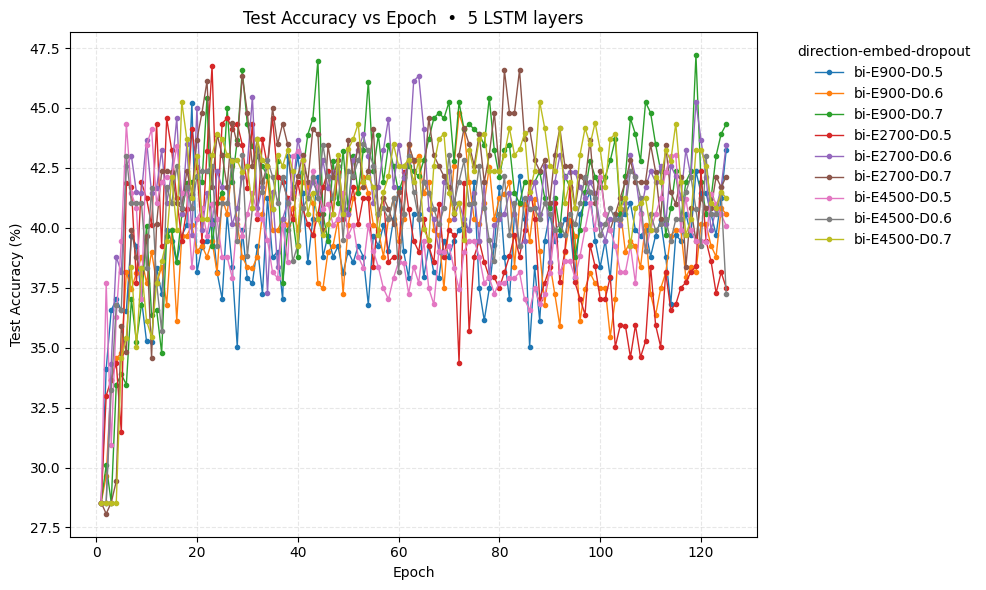

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers5.png


In [14]:
# ─────────────────────────────────────────────────────────────────────
# 0. Imports & config
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Point this to the directory that *contains* all your metrics files
root = Path("./model2/csv_metrics/metrics_old")     # <- adjust if necessary
csv_files = list(root.rglob("metrics_layers*.csv"))

# File name looks like  metrics_layers{N}_{bidir|uni}_emb{D}_drop{P}.csv
#         stem e.g. --> metrics_layers2_bidir_emb2700_drop0.6
pat = re.compile(r"metrics_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# ─────────────────────────────────────────────────────────────────────
# 1. Helper to read a single CSV and annotate it with the hyper-params
# ─────────────────────────────────────────────────────────────────────
def read_and_annotate(csv_path: Path) -> pd.DataFrame:
    # the metrics_*.csv files already contain raw numbers, so no converters are needed
    df = pd.read_csv(csv_path)

    # Parse the hyper-parameters from the FILE NAME (stem)
    m = pat.fullmatch(csv_path.stem)
    if not m:
        raise ValueError(f"File name {csv_path.name} does not match expected pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)

    return df

# ─────────────────────────────────────────────────────────────────────
# 2. Read every file and concatenate into one tidy DataFrame
# ─────────────────────────────────────────────────────────────────────
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# Optional: multi-index for easier inspection
df_all = df_all.set_index(
    ["layers", "bidir", "emb_dim", "dropout", "Epoch"]
).sort_index()

print("Preview")
print(df_all.head())

# Bring the columns back for plotting
df_filtered = df_all.reset_index()

# ─────────────────────────────────────────────────────────────────────
# 3. Five separate plots: one per 'layers' value
# ─────────────────────────────────────────────────────────────────────
layer_values = sorted(df_filtered["layers"].unique())    # e.g. [1, 2, 3, 4, 5]

out_dir = Path("./plots_by_layer")
out_dir.mkdir(exist_ok=True)

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,    # already a fraction, convert to %
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} LSTM layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False,
    )
    plt.tight_layout()

    fig_path = out_dir / f"test_acc_vs_epoch_layers{layers}.png"
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

### new_data result (Using a pre-trained dataset with increased training data)

Preview
                                    TrainLoss  TrainAcc  TestLoss  TestAcc
layers bidir emb_dim dropout Epoch                                        
1      True  900     0.5     1         1.1087    0.5260    0.8557   0.6708
                             2         0.8257    0.6695    0.6050   0.8019
                             3         0.6443    0.7487    0.4518   0.8755
                             4         0.5273    0.7990    0.3843   0.8887
                             5         0.4543    0.8278    0.3128   0.8954


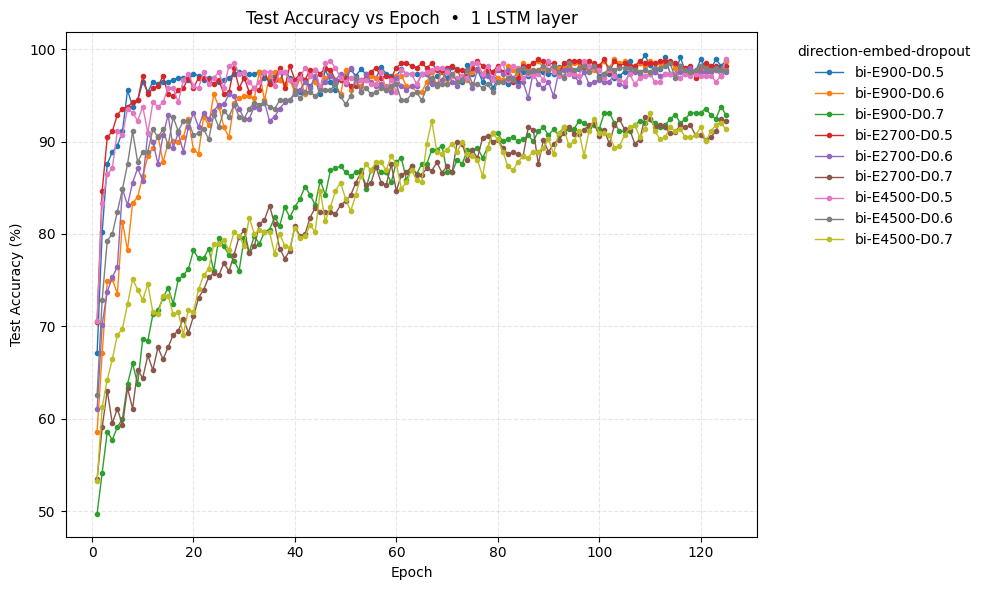

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers1.png


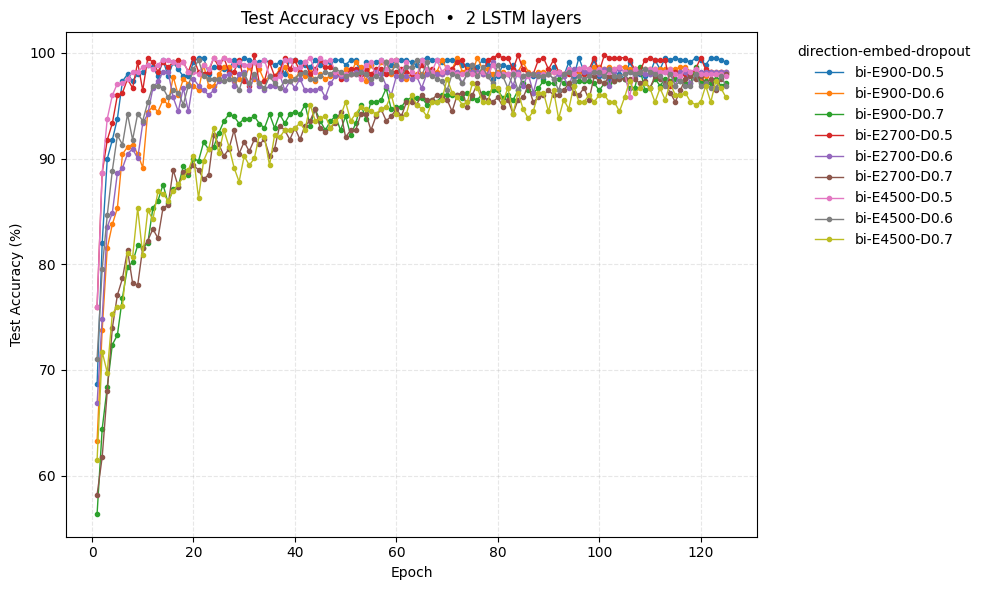

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers2.png


In [15]:
# ─────────────────────────────────────────────────────────────────────
# 0. Imports & config
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Point this to the directory that *contains* all your metrics files
root = Path("./model2/csv_metrics/metrics_new")     # <- adjust if necessary
csv_files = list(root.rglob("metrics_layers*.csv"))

# File name looks like  metrics_layers{N}_{bidir|uni}_emb{D}_drop{P}.csv
#         stem e.g. --> metrics_layers2_bidir_emb2700_drop0.6
pat = re.compile(r"metrics_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# ─────────────────────────────────────────────────────────────────────
# 1. Helper to read a single CSV and annotate it with the hyper-params
# ─────────────────────────────────────────────────────────────────────
def read_and_annotate(csv_path: Path) -> pd.DataFrame:
    # the metrics_*.csv files already contain raw numbers, so no converters are needed
    df = pd.read_csv(csv_path)

    # Parse the hyper-parameters from the FILE NAME (stem)
    m = pat.fullmatch(csv_path.stem)
    if not m:
        raise ValueError(f"File name {csv_path.name} does not match expected pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)

    return df

# ─────────────────────────────────────────────────────────────────────
# 2. Read every file and concatenate into one tidy DataFrame
# ─────────────────────────────────────────────────────────────────────
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# Optional: multi-index for easier inspection
df_all = df_all.set_index(
    ["layers", "bidir", "emb_dim", "dropout", "Epoch"]
).sort_index()

print("Preview")
print(df_all.head())

# Bring the columns back for plotting
df_filtered = df_all.reset_index()

# ─────────────────────────────────────────────────────────────────────
# 3. Five separate plots: one per 'layers' value
# ─────────────────────────────────────────────────────────────────────
layer_values = sorted(df_filtered["layers"].unique())    # e.g. [1, 2, 3, 4, 5]

out_dir = Path("./plots_by_layer")
out_dir.mkdir(exist_ok=True)

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,    # already a fraction, convert to %
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} LSTM layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False,
    )
    plt.tight_layout()

    fig_path = out_dir / f"test_acc_vs_epoch_layers{layers}.png"
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

### data_training package usage
 

In [19]:
from model2.lstm_package import train_lstm
from pathlib import Path

run_dir = Path("model2/saved_models")
run_dir.mkdir(parents=True, exist_ok=True)
run_dir  = "model2/saved_models"

data_dir = Path("model2/data")
data_dir.mkdir(parents=True, exist_ok=True)
data_dir = "model2/data"                 # data/train / data/test

# train
"""
Please run "model2_data_setup_LSTM.ipynb" from model2 before executing this cell!
"""
res = train_lstm(data_dir, run_dir, n_epochs=3, batch_size=32)
print(res)

Loading datasets...
Building vocabulary...


.vector_cache/glove.840B.300d.zip: 2.18GB [10:50, 3.34MB/s]                                
100%|█████████▉| 2196016/2196017 [01:12<00:00, 30103.26it/s]


Starting training...
Epoch 1 | Train loss=1.1255 acc=0.5180 | Test loss=0.8015 acc=0.6857
Epoch 2 | Train loss=0.9144 acc=0.6294 | Test loss=0.6369 acc=0.7733
Epoch 3 | Train loss=0.7638 acc=0.7002 | Test loss=0.4662 acc=0.8129
{'best_test_acc': 0.812869823895968, 'best_test_loss': 0.46618388478572553, 'data': {'fields': 'model2/saved_models/fields.pth', 'label_field': 'model2/saved_models/label_field.pth', 'best_acc': 'model2/saved_models/best_acc.pt', 'best_loss': 'model2/saved_models/best_loss.pt'}, 'config': {'embedding_dim': 300, 'hidden_dim': 256, 'n_layers': 2, 'bidirectional': True, 'dropout': 0.5, 'pad_idx': 1, 'vocab_size': 33275, 'output_dim': 4}}


### data_testing package usage

In [ ]:
from model2.lstm_package import predict_texts  # import the whole module

texts = [
    'so add a fucking rick roll emte with the', 
'i rather the guy learn whatever game he enjoy the fastest. which be stupid lol',
'lucky colat i ve even get in',
'gta online update for june / july timeframe will cop and robber book it',
]

predictions = predict_texts(texts)  

# Example output (each corresponding to the input list order): [3, 0, 2, 3]
print(predictions)  

import pandas as pd                               
from util.preprocessing import load_and_preprocess_data

df = load_and_preprocess_data("Twitter_data/testdata7.csv")
m2_pd = df.toPandas() 
testing_dataset_m2 = m2_pd["Phrase"].astype(str).tolist()   # <- now a plain list[str]
# print(testing_dataset)

# predictions : list of model outputs 
predictions = predict_texts(testing_dataset_m2)
print(predictions)        # raw probabilities (0-1)

# true_labels : list of gold labels
true_labels = m2_pd["Sentiment"].tolist()
print(true_labels)

# convert to hard labels and evaluate
matches = 0                       
total   = len(true_labels)      

for pred, truth in zip(predictions, true_labels):
    if pred == truth:           
        matches += 1

wrong = total - matches
accuracy_pct = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_pct:.3g}%")         
print(f"Number wrong: {wrong} out of {total}")

### Function for evaluating a classifier model: Please see **Section 4**.

---
# **Section 3 Model3: Word2Vec + Random Forest** 

### Models: Word2Vec + Data Analytic Model  

  
  Initially, Doc2Vec was used as embedding model. However, Doc2Vec is better at modelling large files with multiple documents. Withit, only 30% Accuracy was achieved.
  Word2Vec is better at finding pattern in short sentences using window to compare neighbors. Therefore, Word2Vec was implemented for faster training and better fitting of short comments.
  


#### Training in (Github model3 folder): 
- Trains Word2Vec on the large pre-train data  
- Performs hyperparameter GridSearch for both Word2Vec and Random Forest  
- Pre-trains RF on the large dataset  
- Finetunes RF on large + small data (small data weighted higher) 

#### Testing (Code below or in model3 folder):  
- Test Best Model on Test Data

#### Best Metric: 
- Word2Vec Parameters:  
   • vector_size : 200  
   • window      : 8  
   • sg          : 1  
   • epochs      : 40  
   • negative    : 15  

- Random Forest Parameters:  
   • class_weight: balanced  
   • max_depth   : 12  
   • min_samples_leaf: 2  
   • n_estimators: 300    

   #
Best Train Accuracy: 0.9949664429530202  
Best Test Accuracy: 0.8287153652392947  


In [1]:
#loading model from hf
from huggingface_hub import hf_hub_download
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser
import joblib

repo_id = "chrislhg/word2vec-rf"

# Download model files
w2v_path = hf_hub_download(repo_id=repo_id, filename="word2vec_best.model")
clf_path = hf_hub_download(repo_id=repo_id, filename="best_classifier.pkl")
phraser_path = hf_hub_download(repo_id=repo_id, filename="bigram_phraser.model")

# Load models
w2v = Word2Vec.load(w2v_path)
clf_model3 = joblib.load(clf_path)
phraser = Phraser.load(phraser_path)

In [ ]:
#testing
import os
import sys
import joblib
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from util.preprocessing import load_and_preprocess_data
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser
from huggingface_hub import hf_hub_download
from sklearn.metrics import f1_score, confusion_matrix

#Initialize Spark session
spark = SparkSession.builder.appName("Inference").getOrCreate()
spark.sparkContext.addPyFile(os.path.abspath('util/preprocessing.py'))

# Load and preprocess training data
train_df = load_and_preprocess_data("Twitter_data/traindata7.csv")
train_pd = train_df.toPandas()

# Predict on training data
emb_train = np.array([
    np.mean([w2v.wv[t] for t in phraser[row['Phrase'].split()] if t in w2v.wv], axis=0)
    if any(t in w2v.wv for t in phraser[row['Phrase'].split()])
    else np.zeros(w2v.vector_size)
    for _, row in train_pd.iterrows()
])
pred_train = clf_model3.predict(emb_train)

# Calculate training accuracy
train_accuracy = (pred_train == train_pd['Sentiment']).mean()
print("Final training accuracy:", train_accuracy)

# Calculate additional metrics for training data
train_f1_score = f1_score(train_pd['Sentiment'], pred_train, average='weighted')
train_confusion_matrix = confusion_matrix(train_pd['Sentiment'], pred_train)

print("Training F1 Score:", train_f1_score)
print("Training Confusion Matrix:\n", train_confusion_matrix)

# Load and preprocess test data
test_df = load_and_preprocess_data("Twitter_data/testdata7.csv")
test_pd = test_df.toPandas()

# Predict on test data
emb_test = np.array([
    np.mean([w2v.wv[t] for t in phraser[row['Phrase'].split()] if t in w2v.wv], axis=0)
    if any(t in w2v.wv for t in phraser[row['Phrase'].split()])
    else np.zeros(w2v.vector_size)
    for _, row in test_pd.iterrows()
])
pred_test = clf_model3.predict(emb_test)

# Calculate test accuracy
test_accuracy = (pred_test == test_pd['Sentiment']).mean()
print("Final test accuracy:", test_accuracy)

# Please see *Section 4* for more test results.

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/22 15:52:26 WARN Utils: Your hostname, Marcuss-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.216 instead (on interface en0)
25/11/22 15:52:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/22 15:52:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/22 15:52:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Final training accuracy: 0.9949664429530202
Training F1 Score: 0.9949649030650123
Training Confusion Matrix:
 [[177   0   0   1]
 [  0 165   0   0]
 [  0   0 106   0]
 [  2   0   0 145]]
Final test accuracy: 0.8287153652392947
Test F1 Score: 0.8274335056968414
Test Confusion Matrix:
 [[114   6   0   0]
 [ 12  91   1   2]
 [ 10   5  47   4]
 [ 15  10   3  77]]


Test on sample:

In [4]:
#test on simple sample

# Sample texts for prediction
sample_texts = [
    'I love this!',
    'bad',
    'Sounds alright.'
]

# Function to preprocess the input text and get predictions
def predict_sentiment(sample_texts):
    embeddings = np.array([
        np.mean([w2v.wv[t] for t in phraser[text.split()] if t in w2v.wv], axis=0)
        if any(t in w2v.wv for t in phraser[text.split()])
        else np.zeros(w2v.vector_size)
        for text in sample_texts
    ])
    
    predictions = clf_model3.predict(embeddings)
    return predictions

# Predict sentiments for the sample texts
predicted_sentiments = predict_sentiment(sample_texts)

# Output the predictions
for text, sentiment in zip(sample_texts, predicted_sentiments):
    print(f"Text: '{text}' => Predicted Sentiment: {sentiment}")

Text: 'I love this!' => Predicted Sentiment: 1
Text: 'bad' => Predicted Sentiment: 0
Text: 'Sounds alright.' => Predicted Sentiment: 3


---
# **Section 3 Model4: CountVectorizer + Decision Tree**

## Model Description

Model 4 applies a **Bag-of-Words (BoW)** text embedding using **CountVectorizer**, combined with a **Decision Tree classifier**.  
This represents a classical machine-learning approach and serves as a baseline for comparing against more advanced models.

### Why CountVectorizer?

CountVectorizer converts text into a sparse matrix of token counts.  
It is:

- Simple and fast  
- Easy to interpret  
- Suitable for short text such as tweets  
- Compatible with tree-based models  

### Why Decision Tree?

Decision Trees:

- Are highly interpretable  
- Capture nonlinear patterns  
- Require minimal preprocessing  
- Train very fast  

However, they can overfit easily on sparse text data. To mitigate this, hyperparameter tuning is used.

## Implementation

Model 4 is organized as a reusable Python package under: model4/package/


Main components:

- `vectorizers.py` → CountVectorizer configuration  
- `decision_tree_model.py` → DecisionTreeSentiment class  
- `preprocess.py` → Text cleaning  
- `data_loader.py` → CSV loading  
- `__init__.py` → Package exports

The model pipeline:

1. **CountVectorizer** (with tunable n-grams, min_df, max_features)  
2. **DecisionTreeClassifier**

Hyperparameters tuned using **GridSearchCV** include:

- `vec__ngram_range`
- `vec__min_df`
- `vec__max_features`
- `clf__criterion`
- `clf__max_depth`
- `clf__min_samples_split`
- `clf__min_samples_leaf`

## Training Procedure

Example code used for training:

In [3]:
from model4.package import DecisionTreeSentiment, load_dataset

X_train, y_train, X_test, y_test = load_dataset(
    'Twitter_data/traindata7.csv',
    'Twitter_data/testdata7.csv',
    text_col = "Phrase",
    label_col = "Sentiment"
)

model = DecisionTreeSentiment()

best_params, best_score = model.train(X_train, y_train)
train_acc, train_loss = model.evaluate(X_train, y_train)
test_acc, test_loss = model.evaluate(X_test, y_test)

print('Training Accuracy: ', train_acc)
print('Training Loss: ', train_loss)
print('Testing Accuracy: ', test_acc)
print('Testing Loss: ', test_loss)

print("Best Hyperparameters:")
print(best_params)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Training Accuracy:  0.4395973154362416
Training Loss:  0.5604026845637584
Testing Accuracy:  0.37531486146095716
Testing Loss:  0.6246851385390428
Best Hyperparameters:
{'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'vec__max_features': 5000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


## Model Initialization

In [9]:
# After training
tree = DecisionTreeSentiment()
tree.train(X_train, y_train)

# Extract objects from the pipeline
vectorizer4 = tree.model.named_steps["vec"]
model4 = tree.model.named_steps["clf"]

# Please see *Section 4* for more test results.

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


## Important Features Bar Chart Code

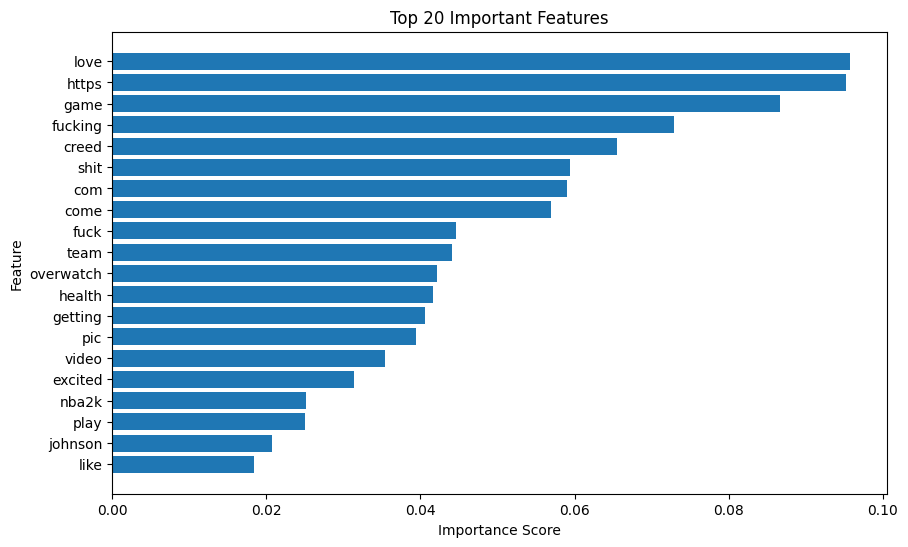

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names from CountVectorizer
feature_names = vectorizer4.get_feature_names_out()

# Tree feature importance
importances = model4.feature_importances_

# Sort top 20 features
idx = np.argsort(importances)[-20:]
top_features = feature_names[idx]
top_importance = importances[idx]

plt.figure(figsize=(10,6))
plt.barh(top_features, top_importance)
plt.title("Top 20 Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

This process returns:

- `Best hyperparameters`

- `Training accuracy & loss`

- `Testing accuracy & loss`

## Summary

Model 4 demonstrates a traditional NLP pipeline using CountVectorizer and Decision Tree classification.
While easy to implement and interpret, it generally underperforms compared to more sophisticated models.
Nonetheless, it provides an important baseline for evaluating model improvements across the project.

---

## **Section 3 Model5: TF-IDF + Naive Bayes**

#### This part introduces the approach of using Naive Bayes as the data analytical model and TF-IDF as the text-embedding model for Twitter sentiment analysis. Here are the testing done for these two models.
#### For Naive Bayes, the function `MultinomialNB()` only has a tunable parameter `alpha` based on the dataset provided, which is 1 by default. Moreover, multinominal Naive Bayes is used as we have a multi-class (>2) dataset. Therefore, this part will focus on the TF-IDF embedding model part.
#### 1. For TF-IDF, I first set the parameters in `TfidfVectorizer()` to be `min_df=2, max_df=0.95, ngram_range=(1,1)`, the result is not satisfactory. 
#### 2. Next, in TF-IDF, I set the parameters in `TfidfVectorizer()` to be `min_df=4, max_df=0.95, ngram_range=(1,2)`, the result has improved a bit (test accuracy) but still far from perfect. 
#### 3. Finally, I used a further fine-tuned training dataset (called a "pre-trained dataset"), trained by a pre-trained model with DNN from the other groupmate, to train a TF-IDF and Naive Bayes models, which obtain a significantly better result.

In [8]:
# Implement here
from model5.package.model import load_saved_model, evaluate_saved_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path
import pandas as pd

# Paths to CSV files
pretrain_csv_path = 'Twitter_data/pre_traindata7.csv'
train_csv_path = 'Twitter_data/traindata7.csv'
test_csv_path = 'Twitter_data/testdata7.csv'
outdir = Path("./model5/plots")
outdir.mkdir(exist_ok=True)

sample_texts = ["I love this!", "I hate this!", "Sounds alright."]

# Get the true labels from the test CSV
df = pd.read_csv(test_csv_path)
testing_dataset = df["Phrase"].astype(str).tolist()
true_labels = df["Sentiment"].tolist()

### 1. Test with standard model trained with standard dataset.

First test. <br>
(Parameters for TF-IDF: min_df=2, max_df=0.95, ngram_range=(1,1))

In [9]:
'''
1. Test with standard model trained with standard dataset.
(Parameters for TF-IDF: min_df=2, max_df=0.95, ngram_range=(1,1))
'''
# Initialize the models
model5_standard = load_saved_model('model5/saved_models_standard')

model5_standard_tfidf_model: TfidfVectorizer = model5_standard['embedding']
model5_standard_nb_model: MultinomialNB = model5_standard['model']

# Evaluate the model on training and testing datasets
model5_standard_eval_result = evaluate_saved_model(model5_standard, train_csv_path, test_csv_path)

# Obtain the train and test losses and accuracies from evaluation result
model5_standard_train_loss      = model5_standard_eval_result.get('train').get('loss')
model5_standard_train_accuracy  = model5_standard_eval_result.get('train').get('accuracy')
model5_standard_test_loss       = model5_standard_eval_result.get('test').get('loss')
model5_standard_test_accuracy   = model5_standard_eval_result.get('test').get('accuracy')

print("\nEvaluation Results for Standard Model:")
print(f"Train loss: {model5_standard_train_loss}, Train accuracy: {model5_standard_train_accuracy}")
print(f"Test loss: {model5_standard_test_loss}, Test accuracy: {model5_standard_test_accuracy}")

# Prediction Result
embedded_texts = model5_standard_tfidf_model.transform(sample_texts)
nb_predictions = model5_standard_nb_model.predict(embedded_texts)
print("\nSample Predictions:")
for t, p in zip(sample_texts, nb_predictions):
    print(f"Text: '{t}' => Predicted Sentiment: {p}")


Evaluation Results for Standard Model:
Train loss: 0.9161253411038153, Train accuracy: 78.35570469798657
Test loss: 1.2396074540171473, Test accuracy: 47.607052896725435

Sample Predictions:
Text: 'I love this!' => Predicted Sentiment: 1
Text: 'I hate this!' => Predicted Sentiment: 1
Text: 'Sounds alright.' => Predicted Sentiment: 0


### Test with tuned model trained with standard dataset.

Second test. <br>
(Parameters for TF-IDF: min_df=4, max_df=0.95, ngram_range=(1,2))

In [11]:
'''
2. Test with tuned model trained with standard dataset.
(Parameters for TF-IDF: min_df=4, max_df=0.95, ngram_range=(1,2))
'''
# Initialize the models
model5_tuned = load_saved_model('model5/saved_models_tuned')

model5_tuned_tfidf_model: TfidfVectorizer = model5_tuned['embedding']
model5_tuned_nb_model: MultinomialNB = model5_tuned['model']

# Evaluate the model on training and testing datasets
model5_tuned_eval_result = evaluate_saved_model(model5_tuned, train_csv_path, test_csv_path)

model5_tuned_train_loss      = model5_tuned_eval_result.get('train').get('loss')
model5_tuned_train_accuracy  = model5_tuned_eval_result.get('train').get('accuracy')
model5_tuned_test_loss       = model5_tuned_eval_result.get('test').get('loss')
model5_tuned_test_accuracy   = model5_tuned_eval_result.get('test').get('accuracy')

print("\nEvaluation Results for Tuned Model:")
print(f"Train loss: {model5_tuned_train_loss}, Train accuracy: {model5_tuned_train_accuracy}")
print(f"Test loss: {model5_tuned_test_loss}, Test accuracy: {model5_tuned_test_accuracy}")

# Prediction Result
embedded_texts = model5_tuned_tfidf_model.transform(sample_texts)
nb_predictions = model5_tuned_nb_model.predict(embedded_texts)

print("\nSample Predictions:")
for t, p in zip(sample_texts, nb_predictions):
    print(f"Text: '{t}' => Predicted Sentiment: {p}")


Evaluation Results for Tuned Model:
Train loss: 0.9433591455740173, Train accuracy: 75.50335570469798
Test loss: 1.2211144372109568, Test accuracy: 50.62972292191436

Sample Predictions:
Text: 'I love this!' => Predicted Sentiment: 1
Text: 'I hate this!' => Predicted Sentiment: 1
Text: 'Sounds alright.' => Predicted Sentiment: 0


#### Test with tuned model trained with **pre-trained** dataset.
Third test. <br>
Same parameters as in the second test. This is the best model obtained for TF-IDF with Naive Bayes models.

In [12]:
'''
3. Test with tuned model trained with *pre-trained* dataset.
(Parameters for TF-IDF: min_df=4, max_df=0.95, ngram_range=(1,2))
'''
# Initialize the models
model5_pretrain = load_saved_model('model5/saved_models_pretrain7')

model5_pretrain_tfidf_model: TfidfVectorizer = model5_pretrain['embedding']
model5_pretrain_nb_model: MultinomialNB = model5_pretrain['model']

# Evaluate the model on training and testing datasets
model5_pretrain_eval_result = evaluate_saved_model(model5_pretrain, pretrain_csv_path, test_csv_path)

model5_pretrain_train_loss      = model5_pretrain_eval_result.get('train').get('loss')
model5_pretrain_train_accuracy  = model5_pretrain_eval_result.get('train').get('accuracy')
model5_pretrain_test_loss       = model5_pretrain_eval_result.get('test').get('loss')
model5_pretrain_test_accuracy   = model5_pretrain_eval_result.get('test').get('accuracy')

print("\nEvaluation Results for Pretrained Model:")
print(f"Train loss: {model5_pretrain_train_loss}, Train accuracy: {model5_pretrain_train_accuracy}")
print(f"Test loss: {model5_pretrain_test_loss}, Test accuracy: {model5_pretrain_test_accuracy}")

# Prediction Result
embedded_texts = model5_pretrain_tfidf_model.transform(sample_texts)
nb_predictions = model5_pretrain_nb_model.predict(embedded_texts)

print("\nSample Predictions:")
for t, p in zip(sample_texts, nb_predictions):
    print(f"Text: '{t}' => Predicted Sentiment: {p}")


Evaluation Results for Pretrained Model:
Train loss: 0.5177415981622627, Train accuracy: 85.63328636664573
Test loss: 0.5199800017170164, Test accuracy: 84.38287153652394

Sample Predictions:
Text: 'I love this!' => Predicted Sentiment: 1
Text: 'I hate this!' => Predicted Sentiment: 0
Text: 'Sounds alright.' => Predicted Sentiment: 3


### Prelimary analysis with line graphs.
The line graph of the training accuracies and testing accuracies for each tested model.

In [13]:
import matplotlib.pyplot as plt

# Prepare data for plotting
models = ['Standard', 'Fine-Tuned', 'Pretrained Training Data']
train_accuracies = [
    model5_standard_train_accuracy,
    model5_tuned_train_accuracy,
    model5_pretrain_train_accuracy
]
test_accuracies = [
    model5_standard_test_accuracy,
    model5_tuned_test_accuracy,
    model5_pretrain_test_accuracy
]
train_losses = [
    model5_standard_train_loss,
    model5_tuned_train_loss,
    model5_pretrain_train_loss
]  
test_losses = [
    model5_standard_test_loss,
    model5_tuned_test_loss,
    model5_pretrain_test_loss
]
x = range(len(models))

outdir.mkdir(exist_ok=True)

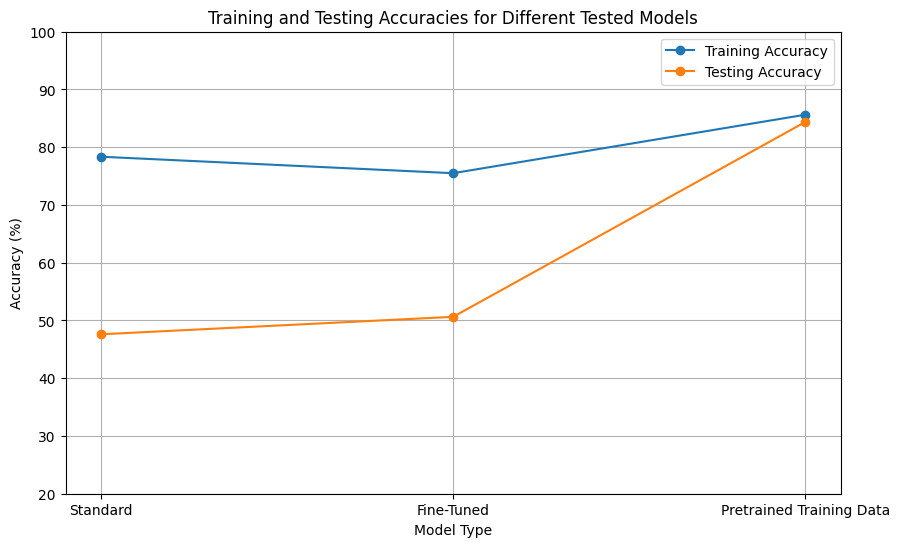

Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/model5/plots/training_testing_acc.png


In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(x, test_accuracies, marker='o', label='Testing Accuracy')
plt.xticks(x, models)
plt.ylim(20, 100)
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies for Different Tested Models')
plt.legend()
plt.grid(True)

fig_path = outdir / f"training_testing_acc.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Saved: {fig_path.resolve()}")

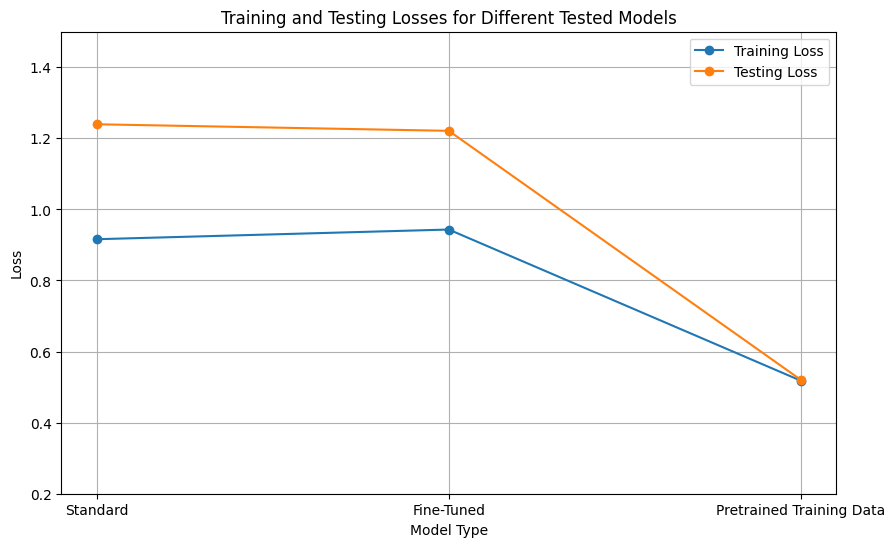

Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/model5/plots/training_testing_loss.png


In [15]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, marker='o', label='Training Loss')
plt.plot(x, test_losses, marker='o', label='Testing Loss')
plt.xticks(x, models)
plt.ylim(0.2, 1.5)
plt.xlabel('Model Type')
plt.ylabel('Loss')
plt.title('Training and Testing Losses for Different Tested Models')
plt.legend()
plt.grid(True)

fig_path = outdir / f"training_testing_loss.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Saved: {fig_path.resolve()}")

---
## **Section 3 Model6: Word2vec + Support Vector Machine**

In [17]:
from pyspark.ml import PipelineModel

# Change above example with this line to use 'word2vec_svm'
# Load the model
pipeline_model6 = PipelineModel.load("model6/word2vec_svm")
predictions = pipeline_model6.transform(test_df)
print(predictions)
# --- Spark imports ---
import pyspark.sql.functions as F

# 1.  Make sure the column is really integer-typed (optional but clean)
predictions_int = predictions.withColumn(
    "prediction_int", F.col("prediction").cast("int")
)

# 2.  Pull that single column back to the driver and flatten it
pred_list6: list[int] = (
    predictions_int
        .select("prediction_int")      # DataFrame[ prediction_int: int ]
        .rdd                           # -> RDD[Row(prediction_int=int)]
        .flatMap(lambda row: row)      # -> RDD[int]
        .collect()                     # -> list[int]
)

print(pred_list6)     # e.g. [1, 0, 2, 1, 1, ...]

DataFrame[Phrase: string, Sentiment: int, words: array<string>, features: vector, rawPrediction: vector, prediction: double]


25/11/22 15:54:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


[0, 1, 0, 3, 1, 3, 3, 0, 0, 2, 0, 0, 3, 2, 0, 0, 1, 3, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 0, 1, 2, 0, 0, 1, 0, 3, 2, 0, 0, 1, 0, 0, 1, 3, 2, 1, 0, 1, 0, 2, 2, 3, 1, 2, 0, 0, 3, 1, 1, 1, 3, 3, 0, 0, 0, 0, 1, 3, 1, 3, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 3, 1, 0, 0, 1, 0, 3, 1, 1, 0, 1, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3, 0, 2, 1, 3, 1, 3, 0, 0, 3, 0, 0, 1, 3, 0, 3, 1, 1, 2, 0, 1, 3, 0, 1, 2, 0, 3, 2, 0, 0, 1, 3, 1, 1, 2, 0, 0, 3, 0, 3, 3, 3, 1, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 1, 3, 0, 1, 0, 1, 1, 1, 1, 1, 3, 0, 0, 1, 0, 3, 0, 0, 1, 1, 0, 1, 0, 1, 3, 3, 1, 1, 0, 0, 3, 0, 1, 0, 1, 0, 3, 0, 3, 0, 0, 0, 0, 1, 3, 1, 0, 1, 0, 2, 3, 1, 1, 1, 3, 0, 2, 0, 0, 1, 1, 1, 3, 3, 0, 0, 0, 3, 2, 3, 1, 3, 0, 0, 0, 3, 0, 1, 1, 3, 1, 1, 0, 2, 3, 3, 1, 2, 3, 0, 1, 3, 3, 3, 0, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 0, 1, 0, 0, 1, 1, 2, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 3, 1, 3, 3, 0, 1, 3, 1, 3, 0, 3, 3, 2, 0, 1, 0, 3, 0, 1, 3, 2, 0, 3, 3, 0, 3, 0, 3, 3, 1, 3, 0, 2, 3, 2, 0, 3, 0, 3, 1, 3, 0, 1, 1, 3, 3, 3, 1, 3, 1, 

---
## **Section 3 Model7: GloVe + RNN**

Preview
                                    TrainLoss  TrainAcc  TestLoss  TestAcc
layers bidir emb_dim dropout Epoch                                        
1      False 900     0.5     1         1.2875    0.4271    1.1432   0.5038
                             2         1.1473    0.5245    0.9987   0.5706
                             3         1.0455    0.5816    0.9072   0.6042
                             4         0.9611    0.6212    0.8492   0.6533
                             5         0.8855    0.6551    0.7353   0.7399


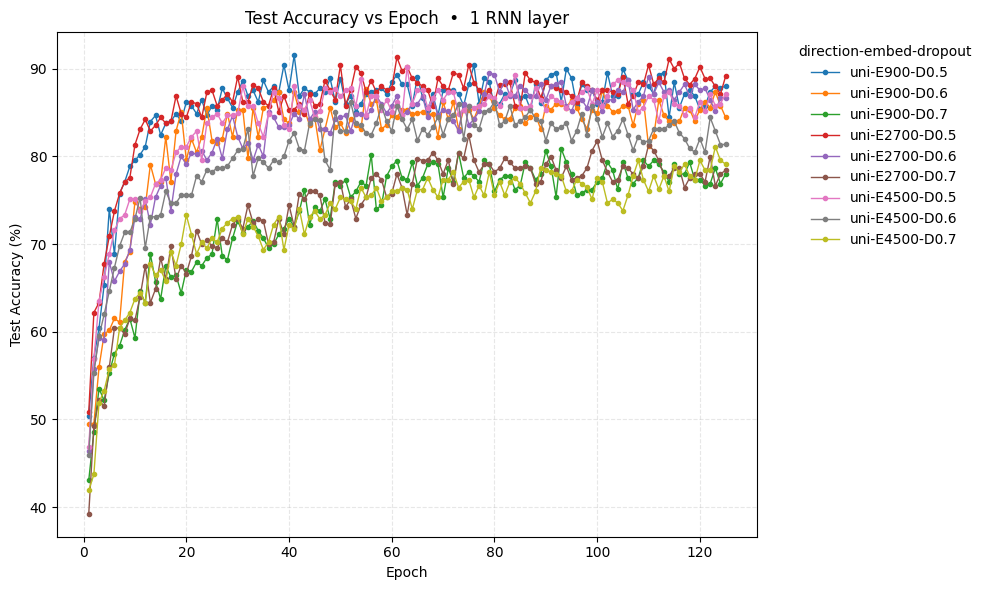

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers1.png


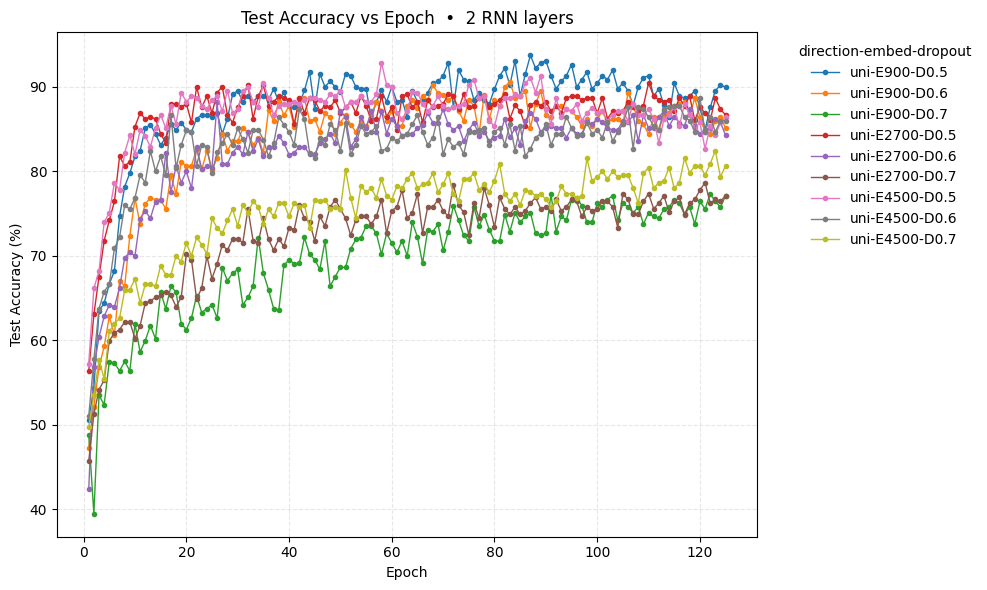

✅  Saved: /Users/MarcussPC/Desktop/Temp/DSAI4205_Project/twitter-sentiment-analysis/plots_by_layer/test_acc_vs_epoch_layers2.png


In [18]:
# ─────────────────────────────────────────────────────────────────────
# 0. Imports & config
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

root = Path("./model7/metrics/")     
csv_files = list(root.rglob("metrics_layers*.csv"))

pat = re.compile(r"metrics_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# ─────────────────────────────────────────────────────────────────────
# 1. Helper to read a single CSV and annotate it with the hyper-params
# ─────────────────────────────────────────────────────────────────────
def read_and_annotate(csv_path: Path) -> pd.DataFrame:
    # the metrics_*.csv files already contain raw numbers, so no converters are needed
    df = pd.read_csv(csv_path)

    # Parse the hyper-parameters from the FILE NAME (stem)
    m = pat.fullmatch(csv_path.stem)
    if not m:
        raise ValueError(f"File name {csv_path.name} does not match expected pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)

    return df

# ─────────────────────────────────────────────────────────────────────
# 2. Read every file and concatenate into one tidy DataFrame
# ─────────────────────────────────────────────────────────────────────
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# Optional: multi-index for easier inspection
df_all = df_all.set_index(
    ["layers", "bidir", "emb_dim", "dropout", "Epoch"]
).sort_index()

print("Preview")
print(df_all.head())

# Bring the columns back for plotting
df_filtered = df_all.reset_index()

# ─────────────────────────────────────────────────────────────────────
# 3. Five separate plots: one per 'layers' value
# ─────────────────────────────────────────────────────────────────────
layer_values = sorted(df_filtered["layers"].unique())    # e.g. [1, 2, 3, 4, 5]

out_dir = Path("./plots_by_layer")
out_dir.mkdir(exist_ok=True)

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,    # already a fraction, convert to %
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} RNN layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False,
    )
    plt.tight_layout()

    fig_path = out_dir / f"test_acc_vs_epoch_layers{layers}.png"
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

---
# **Section 4: Comparison**

## Function to obtain **Confusion Matrix**, **F1-Score**, and **Classifier Report**
### Using true labels from testing dataset and predicted labels from the trained models.

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from util.preprocessing import load_and_preprocess_data

def evaluate_classifier(
    y_true,
    y_pred,
    labels=None,
    plot_heatmap=False,
    heatmap_title="Confusion matrix"
):
    """
    Compute confusion-matrix + F1 scores (+ optional heat-map).

    Parameters
    ----------
    y_true : list | np.ndarray
        Gold labels (scalar values 0 … n_classes-1).
    y_pred : list | np.ndarray
        • Either same shape as y_true (already hard labels)  
        • Or a 2-D array/ list of per-class probabilities/logits
          (shape = [n_samples, n_classes]).
    labels : list, optional
        Order of class ids to appear in the outputs.  
        Default = sorted union of y_true and y_pred.
    plot_heatmap : bool, default False
        If True, draw a seaborn heat-map.
    heatmap_title : str
        Figure title when `plot_heatmap=True`.

    Returns
    -------
    metrics : dict
        {
          'confusion_df' : pd.DataFrame,
          'f1_macro'     : float,
          'f1_micro'     : float,
          'f1_weighted'  : float,
          'classification_report' : str
        }
    """

    # 1) Transparent handling of *probability* vs *label* predictions --------
    y_pred = np.asarray(y_pred)
    if y_pred.ndim == 2:                # probabilities → labels
        y_pred = y_pred.argmax(axis=1)

    y_true = np.asarray(y_true)

    # 2) Determine label order ------------------------------------------------
    if labels is None:
        labels = sorted(set(y_true) | set(y_pred))

    # 3) Confusion matrix -----------------------------------------------------
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(
        cm,
        index=[f"real {l}" for l in labels],
        columns=[f"pred {l}" for l in labels],
    )

    # 4) F1 scores ------------------------------------------------------------
    f1_macro    = f1_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)
    f1_micro    = f1_score(y_true, y_pred, labels=labels, average="micro", zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, labels=labels, average="weighted", zero_division=0)

    # 5) Optional heat-map ----------------------------------------------------
    if plot_heatmap:
        import seaborn as sns, matplotlib.pyplot as plt
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.title(heatmap_title)
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.show()

    # 6) Detailed per-class report -------------------------------------------
    cls_rep = classification_report(y_true, y_pred, labels=labels, zero_division=0)

    metrics = {
        "confusion_df": cm_df,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted,
        "classification_report": cls_rep,
    }
    return metrics

test_df = load_and_preprocess_data("Twitter_data/testdata7.csv")
df = test_df.toPandas()
testing_dataset = df["Phrase"].astype(str).tolist()
true_labels = df["Sentiment"].tolist()
total = len(true_labels)      

## Confusion Matrix, F1-Score, Accuracy metrics

### Baseline Model (DF-IDF + Logistic Regression)

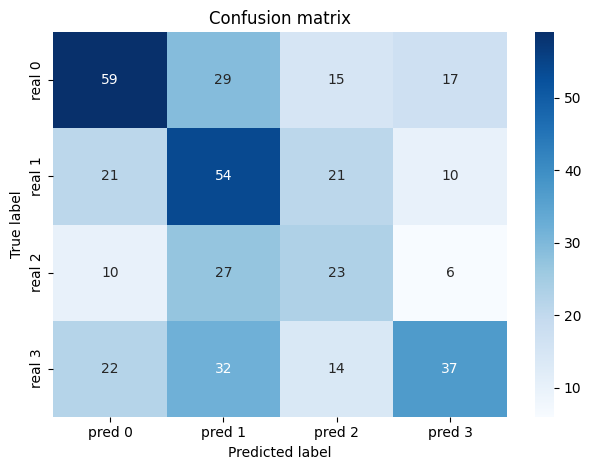

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0      59      29      15      17
real 1      21      54      21      10
real 2      10      27      23       6
real 3      22      32      14      37 

F1-macro    : 0.4245
F1-micro    : 0.4358
F1-weighted : 0.4369

Full report
               precision    recall  f1-score   support

           0       0.53      0.49      0.51       120
           1       0.38      0.51      0.44       106
           2       0.32      0.35      0.33        66
           3       0.53      0.35      0.42       105

    accuracy                           0.44       397
   macro avg       0.44      0.43      0.42       397
weighted avg       0.45      0.44      0.44       397

Accuracy: 43.58%
Number wrong: 224 out of 397


In [14]:
# Compute predictions on the testing dataset using the model
predictions_base = pipeline_model_base.transform(test_df)
predictions_int = predictions_base.withColumn(
    "prediction_int", F.col("prediction").cast("int")
)

pred_list_base: list[int] = (
    predictions_int
        .select("prediction_int")      # DataFrame[ prediction_int: int ]
        .rdd                           # -> RDD[Row(prediction_int=int)]
        .flatMap(lambda row: row)      # -> RDD[int]
        .collect()                     # -> list[int]
)

# Computing the confusion matrix and F1-scores for the model
results_base = evaluate_classifier(true_labels, pred_list_base, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_base["confusion_df"], "\n")
print(f"F1-macro    : {results_base['f1_macro']:.4f}")
print(f"F1-micro    : {results_base['f1_micro']:.4f}")
print(f"F1-weighted : {results_base['f1_weighted']:.4f}\n")
print("Full report\n", results_base["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(pred_list_base, true_labels):
    if pred == truth:           
        matches += 1

wrong_base = total - matches
accuracy_base = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_base:.2f}%")         
print(f"Number wrong: {wrong_base} out of {total}")

### Model 1 (BERT + DNN)

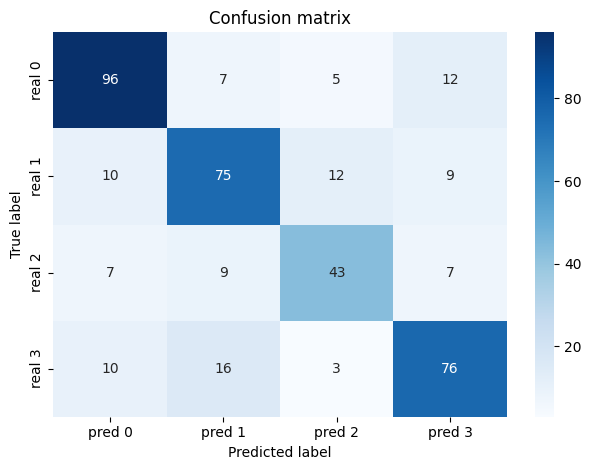

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0      96       7       5      12
real 1      10      75      12       9
real 2       7       9      43       7
real 3      10      16       3      76 

F1-macro    : 0.7221
F1-micro    : 0.7305
F1-weighted : 0.7300

Full report
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       120
           1       0.70      0.71      0.70       106
           2       0.68      0.65      0.67        66
           3       0.73      0.72      0.73       105

    accuracy                           0.73       397
   macro avg       0.72      0.72      0.72       397
weighted avg       0.73      0.73      0.73       397

Accuracy: 73.05%
Number wrong: 107 out of 397


In [18]:
# Compute predictions on the testing dataset using the model
predictions_1 = model1_pipeline.predict(testing_dataset)

# Computing the confusion matrix and F1-scores for the model
results_1 = evaluate_classifier(true_labels, predictions_1, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_1["confusion_df"], "\n")
print(f"F1-macro    : {results_1['f1_macro']:.4f}")
print(f"F1-micro    : {results_1['f1_micro']:.4f}")
print(f"F1-weighted : {results_1['f1_weighted']:.4f}\n")
print("Full report\n", results_1["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(predictions_1, true_labels):
    if pred == truth:           
        matches += 1

wrong_1 = total - matches
accuracy_1 = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_1:.2f}%")         
print(f"Number wrong: {wrong_1} out of {total}")

### Model 2 (GloVe + LSTM)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

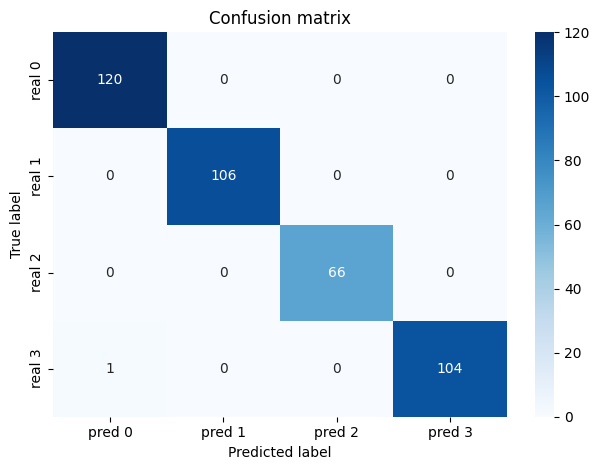

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0     120       0       0       0
real 1       0     106       0       0
real 2       0       0      66       0
real 3       1       0       0     104 

F1-macro    : 0.9978
F1-micro    : 0.9975
F1-weighted : 0.9975

Full report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       120
           1       1.00      1.00      1.00       106
           2       1.00      1.00      1.00        66
           3       1.00      0.99      1.00       105

    accuracy                           1.00       397
   macro avg       1.00      1.00      1.00       397
weighted avg       1.00      1.00      1.00       397

Accuracy: 99.75%
Number wrong: 1 out of 397


In [5]:
from model2.lstm_package import predict_texts
df = load_and_preprocess_data("Twitter_data/testdata7.csv")
m2_pd = df.toPandas() 
testing_dataset_m2 = m2_pd["Phrase"].astype(str).tolist()   # <- now a plain list[str]
# print(testing_dataset)

# predictions : list of model outputs 
predictions_2 = predict_texts(testing_dataset_m2)
print(predictions_2)        # raw probabilities (0-1)

# true_labels : list of gold labels
true_labels = m2_pd["Sentiment"].tolist()
print(true_labels)


# Computing the confusion matrix and F1-scores for the model
results_2 = evaluate_classifier(true_labels, predictions_2, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_2["confusion_df"], "\n")
print(f"F1-macro    : {results_2['f1_macro']:.4f}")
print(f"F1-micro    : {results_2['f1_micro']:.4f}")
print(f"F1-weighted : {results_2['f1_weighted']:.4f}\n")
print("Full report\n", results_2["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(predictions_2, true_labels):
    if pred == truth:           
        matches += 1

wrong_2 = total - matches
accuracy_2 = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_2:.2f}%")         
print(f"Number wrong: {wrong_2} out of {total}")

### Model 3 (Word2vec + Random Forest)

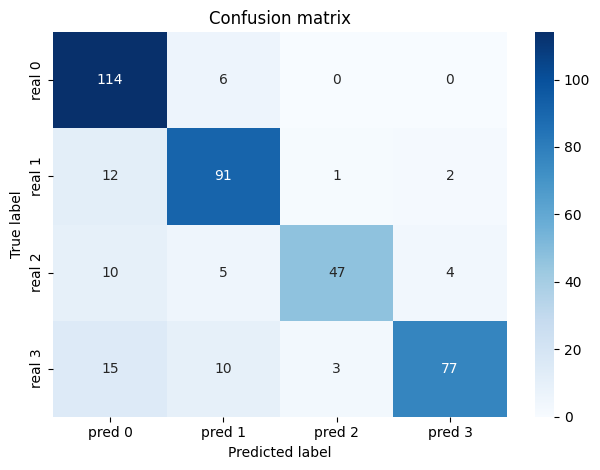

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0     114       6       0       0
real 1      12      91       1       2
real 2      10       5      47       4
real 3      15      10       3      77 

F1-macro    : 0.8247
F1-micro    : 0.8287
F1-weighted : 0.8274

Full report
               precision    recall  f1-score   support

           0       0.75      0.95      0.84       120
           1       0.81      0.86      0.83       106
           2       0.92      0.71      0.80        66
           3       0.93      0.73      0.82       105

    accuracy                           0.83       397
   macro avg       0.85      0.81      0.82       397
weighted avg       0.84      0.83      0.83       397

Accuracy: 82.87%
Number wrong: 68 out of 397


In [ ]:
# Predict on test data
emb_test = np.array([
    np.mean([w2v.wv[t] for t in phraser[row['Phrase'].split()] if t in w2v.wv], axis=0)
    if any(t in w2v.wv for t in phraser[row['Phrase'].split()])
    else np.zeros(w2v.vector_size)
    for _, row in test_pd.iterrows()
])

# Compute predictions on the testing dataset using the model
predictions_3 = clf_model3.predict(emb_test)

# Computing the confusion matrix and F1-scores for the model
results_3 = evaluate_classifier(true_labels, predictions_3, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_3["confusion_df"], "\n")
print(f"F1-macro    : {results_3['f1_macro']:.4f}")
print(f"F1-micro    : {results_3['f1_micro']:.4f}")
print(f"F1-weighted : {results_3['f1_weighted']:.4f}\n")
print("Full report\n", results_3["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(predictions_3, true_labels):
    if pred == truth:           
        matches += 1

wrong_3 = total - matches
accuracy_3 = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_3:.2f}%")         
print(f"Number wrong: {wrong_3} out of {total}")

### Model 4 (CountVectorizer + Decision Tree)

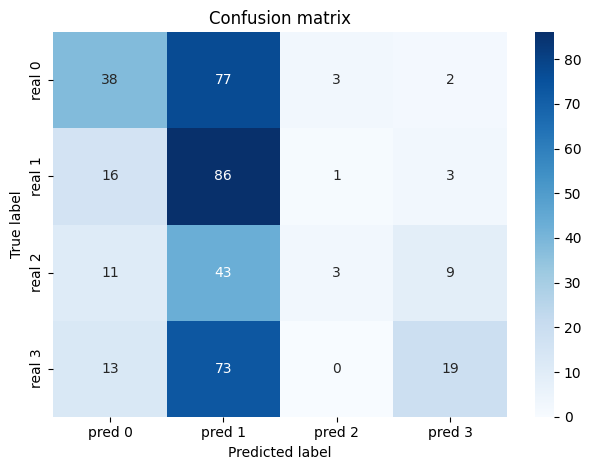

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0      38      77       3       2
real 1      16      86       1       3
real 2      11      43       3       9
real 3      13      73       0      19 

F1-macro    : 0.2970
F1-micro    : 0.3678
F1-weighted : 0.3218

Full report
               precision    recall  f1-score   support

           0       0.49      0.32      0.38       120
           1       0.31      0.81      0.45       106
           2       0.43      0.05      0.08        66
           3       0.58      0.18      0.28       105

    accuracy                           0.37       397
   macro avg       0.45      0.34      0.30       397
weighted avg       0.45      0.37      0.32       397

Accuracy: 36.78%
Number wrong: 251 out of 397


In [ ]:
# Compute predictions on the testing dataset using the model
predictions_4 = model4.predict(vectorizer4.transform(testing_dataset))

# Computing the confusion matrix and F1-scores for the model
results_4 = evaluate_classifier(true_labels, predictions_4, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_4["confusion_df"], "\n")
print(f"F1-macro    : {results_4['f1_macro']:.4f}")
print(f"F1-micro    : {results_4['f1_micro']:.4f}")
print(f"F1-weighted : {results_4['f1_weighted']:.4f}\n")
print("Full report\n", results_4["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(predictions_4, true_labels):
    if pred == truth:           
        matches += 1

wrong_4 = total - matches
accuracy_4 = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_4:.2f}%")         
print(f"Number wrong: {wrong_4} out of {total}")

### Model 5 (TF-IDF + Naive Bayes)

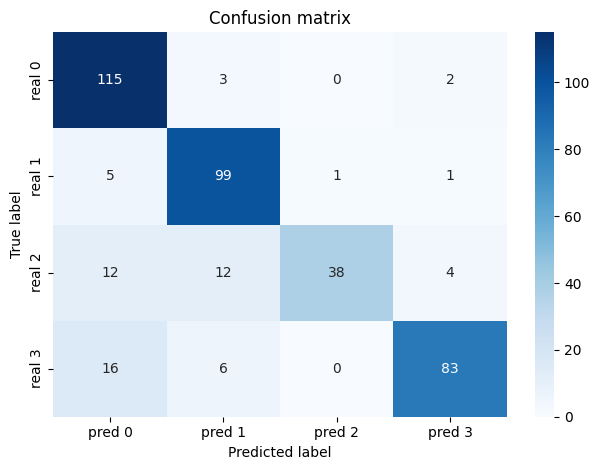

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0     115       3       0       2
real 1       5      99       1       1
real 2      12      12      38       4
real 3      16       6       0      83 

F1-macro    : 0.8274
F1-micro    : 0.8438
F1-weighted : 0.8388

Full report
               precision    recall  f1-score   support

           0       0.78      0.96      0.86       120
           1       0.82      0.93      0.88       106
           2       0.97      0.58      0.72        66
           3       0.92      0.79      0.85       105

    accuracy                           0.84       397
   macro avg       0.87      0.81      0.83       397
weighted avg       0.86      0.84      0.84       397

Accuracy: 84.38%
Number wrong: 62 out of 397


In [ ]:
# Compute predictions on the testing dataset using the model
#predictions5 = model5_tuned_nb_model.predict(model5_tuned_tfidf_model.transform(testing_dataset))
predictions_5 = model5_pretrain_nb_model.predict(model5_pretrain_tfidf_model.transform(testing_dataset))

# Computing the confusion matrix and F1-scores for the model
results_5 = evaluate_classifier(true_labels, predictions_5, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_5["confusion_df"], "\n")
print(f"F1-macro    : {results_5['f1_macro']:.4f}")
print(f"F1-micro    : {results_5['f1_micro']:.4f}")
print(f"F1-weighted : {results_5['f1_weighted']:.4f}\n")
print("Full report\n", results_5["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(predictions_5, true_labels):
    if pred == truth:           
        matches += 1

wrong_5 = total - matches
accuracy_5 = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_5:.2f}%")         
print(f"Number wrong: {wrong_5} out of {total}")

### Model 6 (Word2vec + SVM)

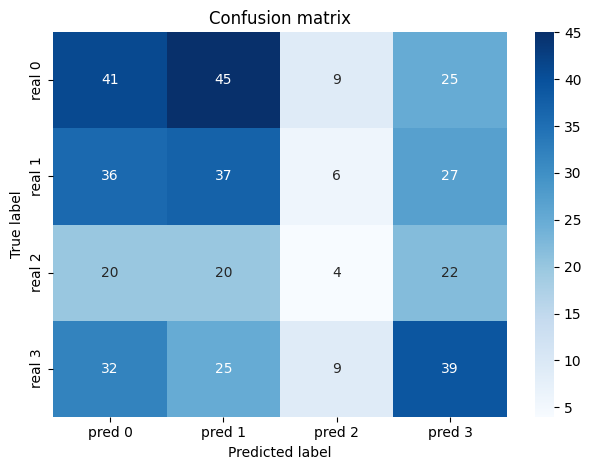

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0      41      45       9      25
real 1      36      37       6      27
real 2      20      20       4      22
real 3      32      25       9      39 

F1-macro    : 0.2725
F1-micro    : 0.3048
F1-weighted : 0.2931

Full report
               precision    recall  f1-score   support

           0       0.32      0.34      0.33       120
           1       0.29      0.35      0.32       106
           2       0.14      0.06      0.09        66
           3       0.35      0.37      0.36       105

    accuracy                           0.30       397
   macro avg       0.27      0.28      0.27       397
weighted avg       0.29      0.30      0.29       397

Accuracy: 30.48%
Number wrong: 276 out of 397


In [ ]:
# Compute predictions on the testing dataset using the model
predictions_6 = pipeline_model6.transform(test_df)
predictions_int = predictions_6.withColumn(
    "prediction_int", F.col("prediction").cast("int")
)

pred_list_6: list[int] = (
    predictions_int
        .select("prediction_int")      # DataFrame[ prediction_int: int ]
        .rdd                           # -> RDD[Row(prediction_int=int)]
        .flatMap(lambda row: row)      # -> RDD[int]
        .collect()                     # -> list[int]
)

# Computing the confusion matrix and F1-scores for the model
results_6 = evaluate_classifier(true_labels, pred_list_6, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_6["confusion_df"], "\n")
print(f"F1-macro    : {results_6['f1_macro']:.4f}")
print(f"F1-micro    : {results_6['f1_micro']:.4f}")
print(f"F1-weighted : {results_6['f1_weighted']:.4f}\n")
print("Full report\n", results_6["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(pred_list_6, true_labels):
    if pred == truth:           
        matches += 1

wrong_6 = total - matches
accuracy_6 = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_6:.2f}%")         
print(f"Number wrong: {wrong_6} out of {total}")

### Model 7 (GloVe + RNN)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

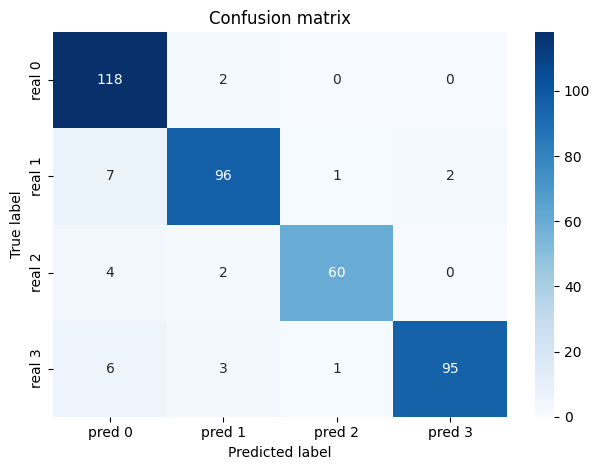

Confusion matrix for the model:
         pred 0  pred 1  pred 2  pred 3
real 0     118       2       0       0
real 1       7      96       1       2
real 2       4       2      60       0
real 3       6       3       1      95 

F1-macro    : 0.9306
F1-micro    : 0.9295
F1-weighted : 0.9297

Full report
               precision    recall  f1-score   support

           0       0.87      0.98      0.93       120
           1       0.93      0.91      0.92       106
           2       0.97      0.91      0.94        66
           3       0.98      0.90      0.94       105

    accuracy                           0.93       397
   macro avg       0.94      0.93      0.93       397
weighted avg       0.93      0.93      0.93       397

Accuracy: 92.95%
Number wrong: 28 out of 397


In [6]:
from model7.rnn_package import predict_texts

df = load_and_preprocess_data("Twitter_data/testdata7.csv")
m7_pd = df.toPandas() 
testing_dataset_m7 = m7_pd["Phrase"].astype(str).tolist()   # <- now a plain list[str]


# true_labels : list of gold labels
true_labels = m7_pd["Sentiment"].tolist()
print(true_labels)
#=========================================
# Compute predictions on the testing dataset using the model
predictions_7 = predict_texts(testing_dataset_m7)

# Computing the confusion matrix and F1-scores for the model
results_7 = evaluate_classifier(true_labels, predictions_7, plot_heatmap=True)
print("Confusion matrix for the model:\n", results_7["confusion_df"], "\n")
print(f"F1-macro    : {results_7['f1_macro']:.4f}")
print(f"F1-micro    : {results_7['f1_micro']:.4f}")
print(f"F1-weighted : {results_7['f1_weighted']:.4f}\n")
print("Full report\n", results_7["classification_report"])

# convert to hard labels and evaluate
matches = 0                       
for pred, truth in zip(predictions_7, true_labels):
    if pred == truth:           
        matches += 1

wrong_7 = total - matches
accuracy_7 = (matches / total) * 100      

# 3 significant figures
print(f"Accuracy: {accuracy_7:.2f}%")         
print(f"Number wrong: {wrong_7} out of {total}")

## Comparison Charts

### Model Test Accuracies

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

models = ['Baseline', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
accuracies = [accuracy_base, accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6, accuracy_7]
x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, accuracies, color='skyblue')
plt.xticks(x, models)
plt.ylim(0, 100)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Baseline and Models 1 to 7')
plt.grid(axis='y')
plt.tight_layout()

fig_path = Path("model_comparison/model_comparison_accuracy.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print(f"Saved: {fig_path.resolve()}")

### Model Test F1-Score

In [ ]:
# Compare the f1-scores of all models
f1_scores_macro = [
    results_base['f1_macro'],
    results_1['f1_macro'],
    results_2['f1_macro'],
    results_3['f1_macro'],
    results_4['f1_macro'],
    results_5['f1_macro'],  
    results_6['f1_macro'],
    results_7['f1_macro']
]
x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, f1_scores_macro, color='salmon')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.xlabel('Models')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score (Macro) Comparison of Baseline and Models 1 to 7')
plt.grid(axis='y')
plt.tight_layout()

fig_path = Path("model_comparison/model_comparison_f1_macro.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print(f"Saved: {fig_path.resolve()}")